<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
     <td align="left"; style="background-color:transparent; width: 33%;"><a href="http://www.math-evry.cnrs.fr/departement/doku.php?id=formation:master:m2ds"><img src="https://github.com/ramp-kits/scMARK_classification/raw/main/evry_logo.png" width="65%"></a></td>
    <td align="center"; style="background-color:transparent; width: 33%;"><a href = "https://dataia.eu/"><img src="https://github.com/ramp-kits/bovine_embryo_survival_prediction/raw/main/DATAIA-h.png" width="80%"></a></td>
    <td align="right"; style="background-color:transparent; width: 33%;"><a href="https://www.inrae.fr"><img src="https://www.inrae.fr/themes/custom/inrae_socle/logo.svg" width="40%"></a></td>
  </tr>
</table> 
</div>


<center><h1>Single-cell RNA-seq classification</h1></center>

<center><h3>A RAMP data-challenge on the prediction of cellular types based on genes expression level </h3></center>
<br/>


<center><i>Nicolas Jouvin (MIA Paris-Saclay, Associate Professor @ Univ. Paris-Saclay), François Caud (DATAIA, Univ. Paris-Saclay) </i></center>

<center><h4> This data-challenge was created for the data-camp course of the Master 2 Data-Science of Université Évry (Paris-Saclay) </h4></center>

# Introduction 

Biologically, [it is known that](https://www.ncbi.nlm.nih.gov/books/NBK26885/), while cells carry (almost) the same genomic information, they tend to *express* only a fraction of their genes leading to specialization into specific *types* with different biological functions. Thus, cell-types study and classification is of primary interest for many biological and medical applications. In the past decade, measuring genes expression level at the scale of a unique cell has become possible with the rise of high-throughput technologies named single-cell RNA-seq (scRNA-seq).

The goal of this data challenge is the **supervised** classification of cell-types thanks to the **scMARK** benchmark dataset from [Mendonca et. al](https://www.biorxiv.org/content/10.1101/2021.12.08.471773v1). The authors compiled 100, 000 cells expression from 10 different studies to serve as a comparison for different machine learning approaches, in an analogy with the MNIST benchmark dataset for computer vision. 

This data-challenge uses a small extraction with only 4 cell-types (the labels to predict) from **scMARK**:

    1. Cancer_cells
    2. NK_cells
    3. T_cells_CD4+
    4. T_cells_CD8+
    
The public dataset contains 1500 points splitted in 1000 training points and 500 test points. It will serve as your local benchmark for developing your submissions. On the server side, your submission will use the whole 1500 public points as the training set, and another **private and unavailable test** dataset, containing 1500 supplementary test points, will be used for the ranking of participants. The labels' distribution in the public (resp. private) training and testing datasets are the same.

# Setup 

If marked as `code`, the two following cells will 

* install the required package dependencies
* download the public data on OSF

They are disabled by default since you only have to call these command once (in your dedicated Python env). You can examine the file, `requirements.txt`, included in the repo to view the list of dependencies.

<div class="alert alert-block alert-info">
<b>Info:</b> Due to the structure of the challenge, libraries not included in `requirements.txt` will need to be added via a pull request to the <a href=https://github.com/ramp-kits/scMARK_classification> GitHub repo </a>.
</div> 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# The data 

### Loading data 
Raw data are stored in h5ad format which can be read via the `scanpy.read_h5ad` function which returns an [AnnData](https://anndata.readthedocs.io/) object.

The `problem.py` file contains the definition of the data-challenge according to the RAMP framework. In addition, it contains an helper functions to import data. 

In [1]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data(
    path="/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers"
)

#X_train, y_train = get_train_data()
X_test, y_test = get_test_data(
    path="/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers"
)


#### Labels proportions
A first inspection of the labels indicates that the classes are imbalanced. 
> Note: the same analysis may be conducted for y_test.

In [ ]:
lab_df = pd.DataFrame({'label': y_train})
lab_df.value_counts(normalize=True)

label       
T_cells_CD8+    0.342
T_cells_CD4+    0.336
Cancer_cells    0.237
NK_cells        0.085
Name: proportion, dtype: float64

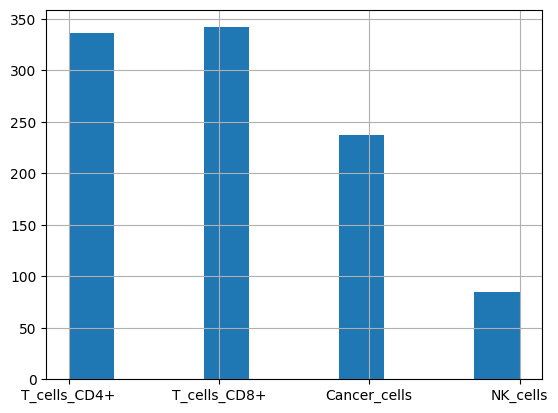

In [ ]:
lab_df.label.hist();

#### Sparse matrix and NumPy arrays

Secondly, looking at the features

In [ ]:
print(X_train.shape)
print(type(X_train))

(1000, 13551)
<class 'scipy.sparse._csr.csr_matrix'>


We see that we have a fairly high dimensional problem with 1000 data points (unique cells) described by 14059 variables (genes). Since we measure expression level, the data is quite sparse, with many unexpressed genes for each cell. Thus, `get_*_data()` functions returns $X$ as a `scipy` [sparse matrix stored in row format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html). This is useful 

    1. To save memory space
    2. Some algorithm may work with scipy's sparse CSR matrices.

Of course many existing algorithm, *e.g.* in scikit-learn, may throw error when given such an object, requiring a `np.array` type. Thankfully the `.toarray()` method straightforwadly converts to NumPy.

In [ ]:
X_train.toarray()

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### A first look at the data

<div class="alert alert-block alert-warning">
<b>Warning:</b> This section purposedly presents a naive example of data manipulation. It is expected of you to dive deeper into the data analysis and do proper pre-processing. 

</div> 


A particularity of RNA-seq data is that total counts may vary widely between cells and/or genes.


In [ ]:
total_genes_counts = X_train.toarray().sum(axis=0)
total_cell_counts = X_train.toarray().sum(axis=1)

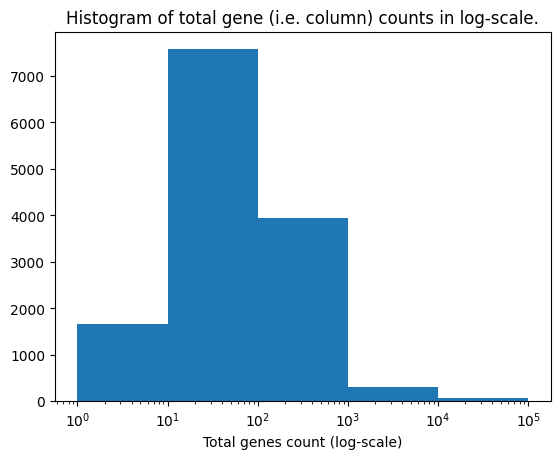

In [ ]:
# plt.hist(np.log10(total_genes_counts), bins = np.arange(6))
plt.hist(total_genes_counts, bins = 10**np.arange(6))
plt.xscale("log")
plt.title("Histogram of total gene (i.e. column) counts in log-scale.")
plt.xlabel('Total genes count (log-scale)')
plt.show()

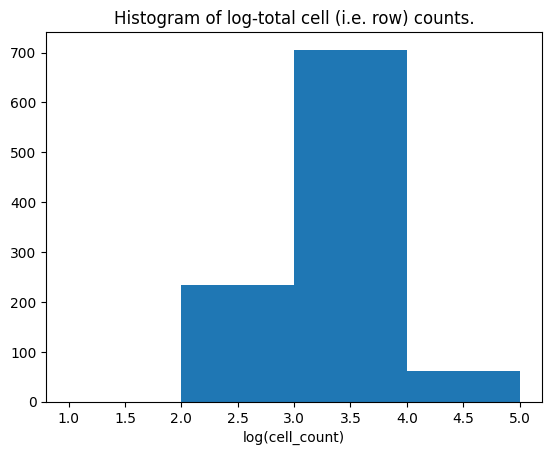

In [ ]:
plt.hist(np.log10(total_cell_counts), bins = np.arange(1,6))
plt.title("Histogram of log-total cell (i.e. row) counts.")
plt.xlabel('log(cell_count)')
plt.show()

This suggests for some normalization of the counts. There are many normalization possible for RNA-seq data, and one of the goal of this challenge is to test for different pre-processing. For simplicity, here we choose to normalize each row (cell) by its total count.

In [ ]:


X_dense = X_train.toarray()

summary = pd.DataFrame({
    "min": [X_dense.min()],
    "max": [X_dense.max()],
    "mean": [X_dense.mean()],
    "median": [np.median(X_dense)],
    "std": [X_dense.std()],
    "sparsity": [(X_dense == 0).sum() / X_dense.size]
})
print(summary)


total_values = X_train.shape[0] * X_train.shape[1]  # nombre total de cases
num_nonzero = X_train.count_nonzero()                # nombre de valeurs non nulles
num_zeros = total_values - num_nonzero              # nombre de zéros
sparsity = num_zeros / total_values

print(f"Nombre total de zéros : {num_zeros:,}")
print(f"Proportion de zéros (sparsité) : {sparsity:.2%}")






   min     max     mean  median       std  sparsity
0  0.0  3260.0  0.24604     0.0  3.538571  0.919478
Nombre total de zéros : 12,459,844
Proportion de zéros (sparsité) : 91.95%


In [ ]:
import pandas as pd

# Conversion en dense
X_dense = X_train.toarray()

# DataFrame
df = pd.DataFrame(X_dense)

# Correction ici
df["label"] = y_train.to_numpy()   # <--- nouveau

# Séparation par classes
df_class0 = df[df["label"] == 0].reset_index(drop=True)
df_class1 = df[df["label"] == 1].reset_index(drop=True)
df_class2 = df[df["label"] == 2].reset_index(drop=True)
df_class3 = df[df["label"] == 3].reset_index(drop=True)


print(df_class0)
print(df)

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
Index: []

[0 rows x 13552 columns]
       0    1    2    3    4    5    6    7    8    9  ...  13542  13543  \
0    1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  ...    0.0    1.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  ...    0.0    0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
995  0.0  0

In [ ]:
moyennes = df.drop(columns="label").mean(axis=0)
print(moyennes)

medians = df.drop(columns="label").median(axis=0)
print(medians)



0        0.258
1        0.068
2        0.028
3        0.063
4        0.056
         ...  
13546    0.018
13547    0.044
13548    0.408
13549    0.077
13550    0.066
Length: 13551, dtype: float32
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
13546    0.0
13547    0.0
13548    0.0
13549    0.0
13550    0.0
Length: 13551, dtype: float32


In [ ]:

gene_means = df_class0.drop(columns="label").mean(axis=0)
top_genes = gene_means.sort_values(ascending=False)

top_genes.head(10)


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
dtype: float64

In [ ]:
def preprocess_X(X):
    X = X.toarray()
    return X / X.sum(axis=1)[:, np.newaxis]

X_train_norm = preprocess_X(X_train)
# sanity check
np.allclose(X_train_norm.sum(axis=1), np.ones(X_train_norm.shape[0]))


True

# The score function

This challenge scores your submissions and ranks participants with a balanced accuracy score, computed via the (unadjusted) sklearn's `balanced_accuracy_score` function.

Balanced accuracy is computed as the average of Recall scores for each class [see implementation for more details](https://github.com/scikit-learn/scikit-learn/blob/8c9c1f27b/sklearn/metrics/_classification.py#L2180). It is between 0 and 1, the higher, the better.

In [ ]:
from sklearn.metrics import balanced_accuracy_score

In [ ]:
# this custom class is used by the challenge and calls 
# balanced_accuracy_score(y_true, y_pred, adjusted=False)
# under the hood
from problem import BalancedAccuracy

# A first (naive) try at the challenge
We now show a first naive attempt at the challenge, and will proceed in two steps :

    1. First, we will construct a classifier step-by-step. 
    2. Then, we will show how to implement this classifier as a proper RAMP submision.
## Step-by-step construction of a classifier

Given the high-dimensional nature of the problem we will construct a classifier: standardize data, do a PCA retaining only the 50 first components, and finally fit a random forest classifier on the 50 first components.

This can be easily implemented as a scikit-learn `Pipeline`.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 50 components", PCA(n_components=50)),
        (
            "Random Forest Classifier",
            RandomForestClassifier(
                max_depth=5, n_estimators=100, max_features=3
            ),
        ),
    ]
)

pipe

Pipeline(steps=[('Scaler', StandardScaler()),
                ('PCA with 50 components', PCA(n_components=50)),
                ('Random Forest Classifier',
                 RandomForestClassifier(max_depth=5, max_features=3))])

In [ ]:
# fit on train
pipe.fit(X_train_norm, y_train)
y_tr_pred = pipe.predict(X_train_norm)

# predict on test
X_test_norm = preprocess_X(X_test)
y_te_pred = pipe.predict(X_test_norm)


Train balanced accuracy : 0.697
Test balanced accuracy : 0.582


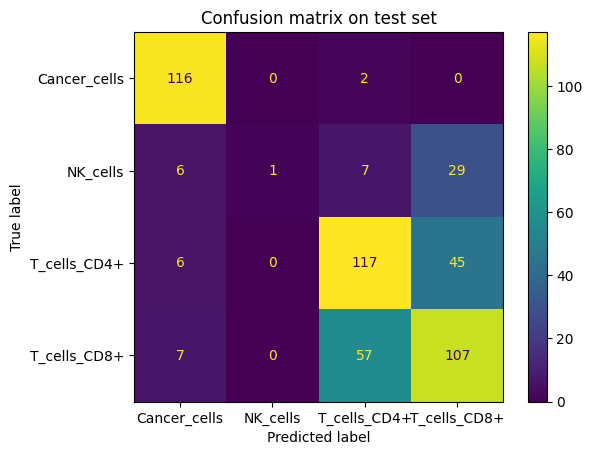

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set");

This naive classifier does a better job than a dummy random classifier which would yield an average balanced accuracy of 1/4. 
However, it never predicts the "NK_cell" type and seems to confuse between the two different "T-cell" types. There seems to be room for improvement. Good news, it is your job ! :)

Next, let's see how to implement this exact same classifier as a receivable RAMP submission

## Designing the RAMP submission
The RAMP challenge is automatized and a submission requires a specific structure described below.


### Mandatory structure of a submission


A submission is stored in `./submissions/<submission_foldername>/` and must contain a Python file named `classifier.py`.

This python script must itself implement (at least) a custom `Classifier` class with
 * A `fit(X, y)` method.
 * A `predict_proba(X)` method.
 
**Warning**: the `X` argument must be understood as the sparse CSR count data matrix obtained by `get_train_data()`. Thus any pre-processing of the count matrix must be done inside the methods.

We illustrate this below with the naive classifier already implemented.

### Illustration with the naive classifier

> Note: The following class is also implemented in `./submissions/starting_kit/classifier.py`.

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


def _preprocess_X(X_sparse):
    # cast a dense array
    X = X_sparse.toarray()

    # normalize each row
    return X / X.sum(axis=1)[:, np.newaxis]


class Classifier(object):
    def __init__(self):
        # Use scikit-learn's pipeline
        self.pipe = make_pipeline(
            StandardScaler(with_mean=True, with_std=True),
            PCA(n_components=550),
            RandomForestClassifier(
                max_depth=5, n_estimators=100, 
                max_features=3
            ),
        )

    def fit(self, X_sparse, y):
        X = _preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        self.classes_ = self.pipe.classes_
        pass

    def predict_proba(self, X_sparse):
        X = _preprocess_X(X_sparse)
        # here we use RandomForest.predict_proba()
        return self.pipe.predict_proba(X)


Below is a simplified version of what RAMP does with your submission.

In [ ]:
clf = Classifier()
clf.fit(X_train, y_train)
# predict_proba 
y_tr_pred_proba = clf.predict_proba(X_train)
y_te_pred_proba = clf.predict_proba(X_test)

# convert to hard classification with argmax
y_tr_pred = clf.classes_[np.argmax(y_tr_pred_proba, axis=1)]
y_te_pred = clf.classes_[np.argmax(y_te_pred_proba, axis=1)]

In [ ]:
print('Train balanced accuracy:', balanced_accuracy_score(y_train, y_tr_pred))
print('Test balanced accuracy:', balanced_accuracy_score(y_test, y_te_pred))

Train balanced accuracy: 0.6666253737782032
Test balanced accuracy: 0.5149964423771293


In reality things are a bit more sophisticated. **Locally**, the RAMP platform averages your classifier preformance over a 5-fold cross-validation scheme implemented for you in the `get_cv` method. The good news is, RAMP automatize everything for you thanks to `ramp-test`. The public train, validation and test performance are shown to you for information. 


<div class="alert alert-block alert-info">
<b>A note on hyper-parameter search</b> RAMP does not perform hyper-parameter tuning, nor grid-search for you. You need to implement this locally, on your own machine, and fix the hyper-parameters by hand in your Classifier class when sending your submission. Another option is to use K-fold cross-validation in the `fit()` method of your classifier, but it could lead to heavy computation times that would delay your research. </a>.
</div> 



### Submitting to RAMP

Before submitting to RAMP, you can test your solution locally to ensure that trivial errors (e.g. typos, path issues, etc.) are resolved. We can test a given submission using the `ramp-test` command that was installed in the virtual environment.  

We'll use the following command:  

`!ramp-test --submission <subm_folder> --quick-test` 

The `!` signals that the command should be run on the command line instead of this notebook.  
`ramp-test` is the command to be executed. It signals ramp to perform a local test. 

`--submission <subm_folder>` specifies which submission to run. You can have multiple potential submissions in the `submissions/` directory; this prevents `ramp` from running all of them (and by default it runs starting_kit).  

In [ ]:
!ramp-test --submission starting_kit

/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/bin/ramp-test: line 2: /Users/eliko/Documents/Documents - MacBook Pro de Eliko/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/bin/python3.10: No such file or directory
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/bin/ramp-test: line 2: exec: /Users/eliko/Documents/Documents - MacBook Pro de Eliko/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/bin/python3.10: cannot execute: No such file or directory


We see that the mean CV scores are consistent with the previous result we had. If you use a classifier with more variance, you would see more variation accross CV-folds. 

<div class="alert alert-info"> 
    
<b>Note on style complicance</b> Every `submissions/*.py` files will be checked for style compliance before running on RAMP server. It is done thanks to the [flake8](https://flake8.pycqa.org/en/latest/) package. Before submitting, you need to fix any error raised by the following terminal command
    
`$flake8 submissions/`
<br/>

The **black** auto-formatting tool works very well to automatically format your code accoring to flake8 standard when saving your files in VScode or PyCharm IDEs. 

You might want to check [this page](https://flake8.pycqa.org/en/3.1.1/user/ignoring-errors.html) for ignoring specific errors in some corner-cases. 

</div>

## Ranking & Leaderboard

**On the server**, the participants are ranked according to the balanced accuracy score on the private test data set. However, only the ranking will be available, and not the score in itself in order to avoid overfitting of this private test set. The score on public test will be available as a proxy but your submission could very well have a better ranking on private with a worst balanced accuracy on public. 

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

# Now it's your turn

Présence de valeurs manquantes : False
             0            1            2            3            4      \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.258000     0.068000     0.028000     0.063000     0.056000   
std       2.355203     0.606419     0.221958     0.274055     0.284508   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max      64.000000    11.000000     4.000000     2.000000     4.000000   

             5            6            7            8            9      ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      0.051000     0.007000     0.055000     0.084000     0.280000  ...   
std       0.592241     0.094657     0.260851     0.359267

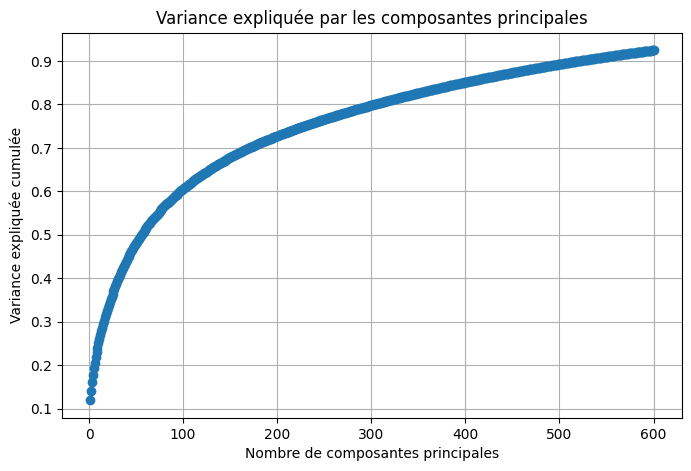

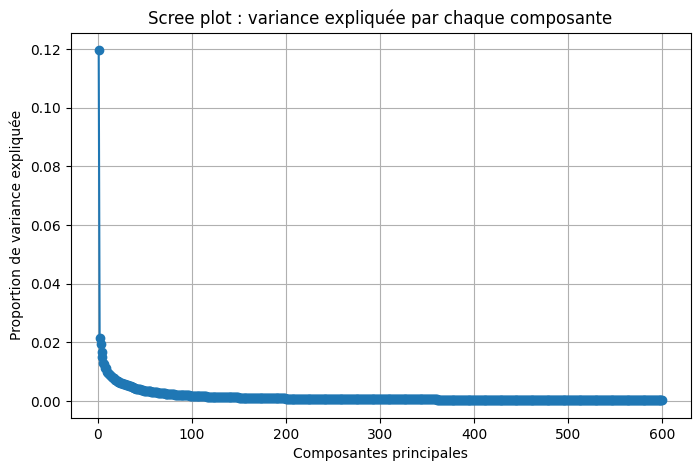

In [ ]:
from sklearn.decomposition import PCA


df = pd.DataFrame(X_train.toarray())  # si c'est sparse, convertir en dense
# Vérifier s'il y a des NaN
print("Présence de valeurs manquantes :", df.isna().any().any())

print(df.describe())


def _preprocess_X(X_sparse):
    # Convertir en matrice dense
    X = X_sparse.toarray()
    
    # Calculer la moyenne et l'écart-type pour chaque gène (colonne)
    gene_mean = X.mean(axis=0)
    gene_std = X.std(axis=0)
    
    # Éviter la division par zéro
    gene_std[gene_std == 0] = 1.0
    
    # Normalisation standard (z-score)
    X_standard = (X - gene_mean) / gene_std
    
    return X_standard




n_cells, n_genes = X_train.shape
print(f"Nombre de cellules : {n_cells}")
print(f"Nombre de gènes (variables) : {n_genes}")


# Supposons que X_standard est le résultat de ta normalisation z-score
n_components = 600  # nombre de composantes principales à conserver
pca = PCA(n_components=n_components)
X_standard = _preprocess_X(X_train)

X_pca = pca.fit_transform(X_standard)  # résultat projeté

plt.figure(figsize=(8,5))
plt.plot(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée par les composantes principales")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_, marker='o')
plt.xlabel("Composantes principales")
plt.ylabel("Proportion de variance expliquée")
plt.title("Scree plot : variance expliquée par chaque composante")
plt.grid(True)
plt.show()



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Créer le modèle
rf = RandomForestClassifier(
    n_estimators=200,   # nombre d'arbres
    max_depth=None,     # profondeur max des arbres
    random_state=42,
    n_jobs=-1           # utiliser tous les cœurs
)

# Entraîner sur les données
rf.fit(X_standard, y_train)


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

Accuracy sur le test set : 0.828
Test balanced accuracy: 0.6848512524248473
              precision    recall  f1-score   support

Cancer_cells       1.00      0.97      0.99       118
    NK_cells       0.00      0.00      0.00        43
T_cells_CD4+       0.79      0.93      0.85       168
T_cells_CD8+       0.76      0.84      0.80       171

    accuracy                           0.83       500
   macro avg       0.64      0.68      0.66       500
weighted avg       0.76      0.83      0.79       500



/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set 

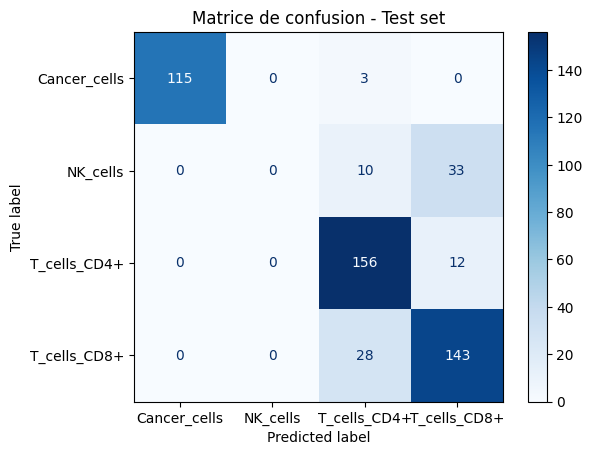

In [ ]:
# Prédictions sur le test set
X_standard_test = _preprocess_X(X_test)
y_test_pred = rf.predict(X_standard_test)

# Accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Accuracy sur le test set :", accuracy_score(y_test, y_test_pred))
print('Test balanced accuracy:', balanced_accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

# Matrice de confusion
cm_test = confusion_matrix(y_test, y_test_pred, labels=rf.classes_)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=rf.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion - Test set")
plt.show()



Présence de valeurs manquantes : False
             0            1            2            3            4      \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.258000     0.068000     0.028000     0.063000     0.056000   
std       2.355203     0.606419     0.221958     0.274055     0.284508   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max      64.000000    11.000000     4.000000     2.000000     4.000000   

             5            6            7            8            9      ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      0.051000     0.007000     0.055000     0.084000     0.280000  ...   
std       0.592241     0.094657     0.260851     0.359267

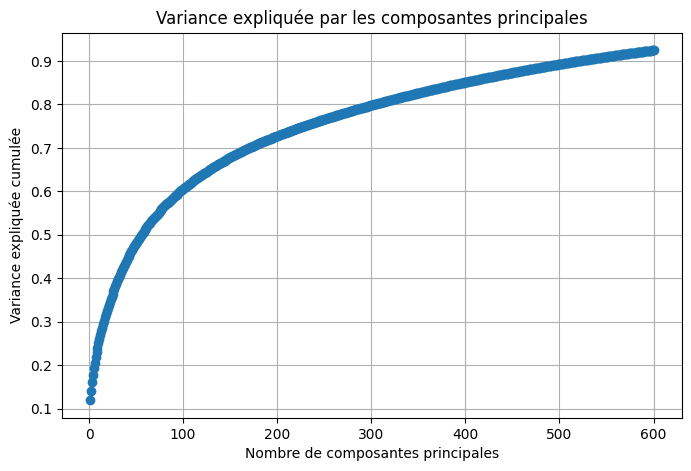

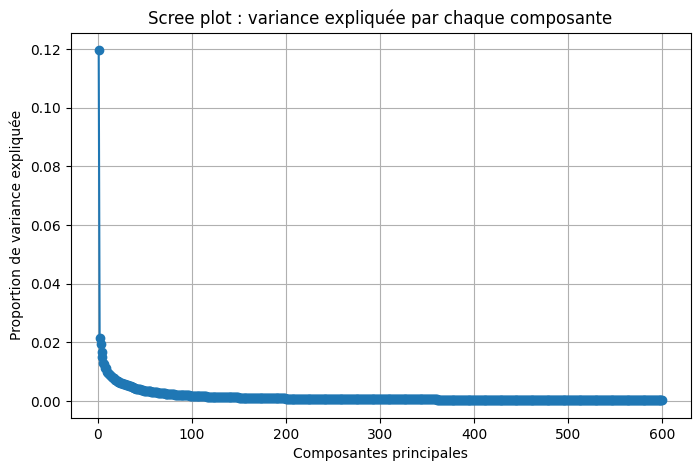

Accuracy sur le test set : 0.792
              precision    recall  f1-score   support

Cancer_cells       0.94      0.98      0.96       118
    NK_cells       1.00      0.09      0.17        43
T_cells_CD4+       0.79      0.83      0.81       168
T_cells_CD8+       0.70      0.80      0.74       171

    accuracy                           0.79       500
   macro avg       0.86      0.68      0.67       500
weighted avg       0.81      0.79      0.77       500



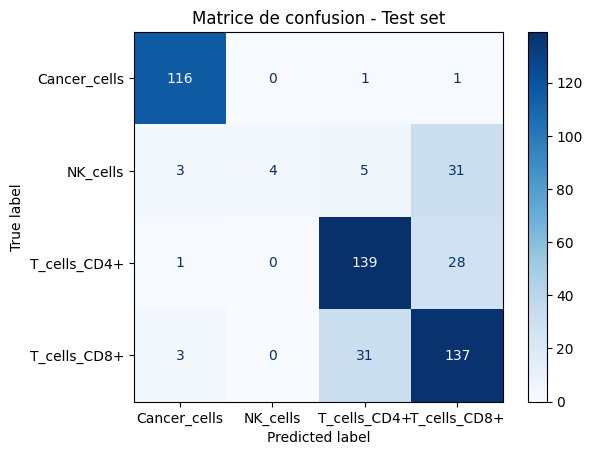

In [ ]:
# ============================================================
# 📦 Imports
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

# ============================================================
# ⚙️ Prétraitement des données
# ============================================================

def preprocess_X(X_sparse, mean=None, std=None):
    """Convertit une matrice sparse en dense et applique un z-score normalisé.
    Si mean et std sont fournis, les utiliser (pour les données de test)."""
    X = X_sparse.toarray() if hasattr(X_sparse, "toarray") else X_sparse
    
    if mean is None or std is None:
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        std[std == 0] = 1.0  # éviter division par zéro

    X_standard = (X - mean) / std
    return X_standard, mean, std

# Vérification des données
df = pd.DataFrame(X_train.toarray())
print("Présence de valeurs manquantes :", df.isna().any().any())
print(df.describe())

n_cells, n_genes = X_train.shape
print(f"Nombre de cellules : {n_cells}")
print(f"Nombre de gènes : {n_genes}")

# Normalisation (z-score sur le jeu d'entraînement)
X_train_std, gene_mean, gene_std = preprocess_X(X_train)

# Normalisation du jeu de test avec les mêmes paramètres
X_test_std, _, _ = preprocess_X(X_test, gene_mean, gene_std)

# ============================================================
# 📊 Analyse en Composantes Principales (PCA)
# ============================================================
n_components = 600
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Variance expliquée cumulée
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée par les composantes principales")
plt.grid(True)
plt.show()

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel("Composantes principales")
plt.ylabel("Proportion de variance expliquée")
plt.title("Scree plot : variance expliquée par chaque composante")
plt.grid(True)
plt.show()

# ============================================================
# 🌲 Modélisation : Random Forest
# ============================================================
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Entraînement sur les données PCA
rf.fit(X_train_pca, y_train)

# Prédictions sur le jeu de test
y_pred = rf.predict(X_test_pca)

# ============================================================
# 📈 Évaluation du modèle
# ============================================================
print("Accuracy sur le test set :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion - Test set")
plt.show()


In [ ]:
from lightgbm import LGBMClassifier
print("✅ LightGBM fonctionne dans le notebook !")


✅ LightGBM fonctionne dans le notebook !


⏳ Entraînement du modèle LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153000
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 600
[LightGBM] [Info] Start training from score -1.439695
[LightGBM] [Info] Start training from score -2.465104
[LightGBM] [Info] Start training from score -1.090644
[LightGBM] [Info] Start training from score -1.072945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

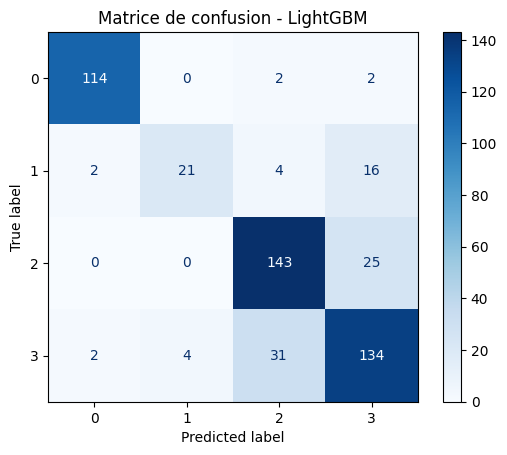

In [ ]:

# ============================================================
# ⚙️ Modèle de Boosting : LightGBM
# ============================================================
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,         # -1 = pas de limite
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("⏳ Entraînement du modèle LightGBM...")
lgbm.fit(X_train_pca, y_train)

# Prédictions
y_pred_lgbm = lgbm.predict(X_test_pca)

# ============================================================
# 📈 Évaluation
# ============================================================
print("\n=== 📊 LightGBM ===")
print("Accuracy :", accuracy_score(y_test, y_pred_lgbm))
print('Test balanced accuracy:', balanced_accuracy_score(y_test,  y_pred_lgbm))

print(classification_report(y_test, y_pred_lgbm))

# Matrice de confusion
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
disp_lgbm = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm)
disp_lgbm.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion - LightGBM")
plt.show()


# NEW

In [ ]:
import numpy as np

X_train = X_train.values if hasattr(X_train, "values") else X_train
y_train = y_train.values.ravel() if hasattr(y_train, "values") else y_train
X_test = X_test.values if hasattr(X_test, "values") else X_test


In [ ]:
X_train_log = np.log1p(X_train)  # log(1 + x) sur le train
X_test_log = np.log1p(X_test)    # log(1 + x) sur le test


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_log, y_train)


ModuleNotFoundError: No module named 'imblearn'

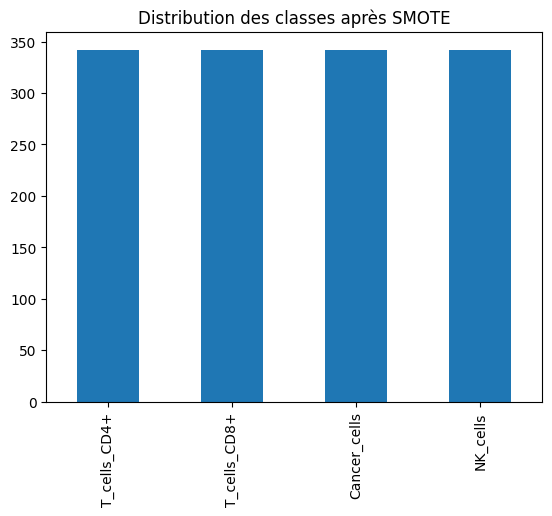

In [ ]:
import matplotlib.pyplot as plt

pd.Series(y_train_resampled).value_counts().plot(kind='bar')
plt.title("Distribution des classes après SMOTE")
plt.show()


In [ ]:
import numpy as np

# Compter le nombre d'exemples par classe
unique, counts = np.unique(y_train_resampled, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Classe {cls}: {count} exemples")


Classe Cancer_cells: 342 exemples
Classe NK_cells: 342 exemples
Classe T_cells_CD4+: 342 exemples
Classe T_cells_CD8+: 342 exemples


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)
X_train_processed = pca.fit_transform(X_train_resampled)  # fit + transform sur train
X_test_processed = pca.transform(X_test_log)             # seulement transform sur test


In [ ]:
print("Train shape:", X_train_processed.shape, y_train_resampled.shape)
print("Test shape:", X_test_processed.shape)


Train shape: (1368, 50) (1368,)
Test shape: (500, 50)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Créer les labels binaires
y_train_binary = np.where(
    (y_train_resampled == "Cancer_cells") | (y_train_resampled == "NK_cells"), 
    "Classe_1", 
    "Classe_2"
)

# Modèle binaire
clf_binary = RandomForestClassifier(random_state=42)
clf_binary.fit(X_train_processed, y_train_binary)

# Prédiction sur le test
y_test_binary_pred = clf_binary.predict(X_test_processed)


In [ ]:
# Classe 1
mask_cl1 = y_train_binary == "Classe_1"
X_train_cl1 = X_train_processed[mask_cl1]
y_train_cl1 = y_train_resampled[mask_cl1]  # valeurs originales : Cancer_cells/NK_cells

# Classe 2
mask_cl2 = y_train_binary == "Classe_2"
X_train_cl2 = X_train_processed[mask_cl2]
y_train_cl2 = y_train_resampled[mask_cl2]  # valeurs originales : T_cells_CD4+/T_cells_CD8+


In [ ]:
clf_cl1 = RandomForestClassifier(random_state=42)
clf_cl1.fit(X_train_cl1, y_train_cl1)

clf_cl2 = RandomForestClassifier(random_state=42)
clf_cl2.fit(X_train_cl2, y_train_cl2)


RandomForestClassifier(random_state=42)

In [ ]:
# Initialiser le tableau final
y_test_final = np.empty_like(y_test_binary_pred, dtype=object)

# Appliquer modèle spécifique à chaque sous-groupe
mask_test_cl1 = y_test_binary_pred == "Classe_1"
mask_test_cl2 = y_test_binary_pred == "Classe_2"

y_test_final[mask_test_cl1] = clf_cl1.predict(X_test_processed[mask_test_cl1])
y_test_final[mask_test_cl2] = clf_cl2.predict(X_test_processed[mask_test_cl2])


In [ ]:
import pandas as pd

pd.Series(y_test_final).value_counts()


T_cells_CD4+    179
T_cells_CD8+    174
Cancer_cells    121
NK_cells         26
Name: count, dtype: int64

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Accuracy classique
acc = accuracy_score(y_test, y_test_final)

# Balanced accuracy (utile si classes déséquilibrées)
bal_acc = balanced_accuracy_score(y_test, y_test_final)

print(f"Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
#print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")


Accuracy: 0.8380
Balanced Accuracy: 0.7746


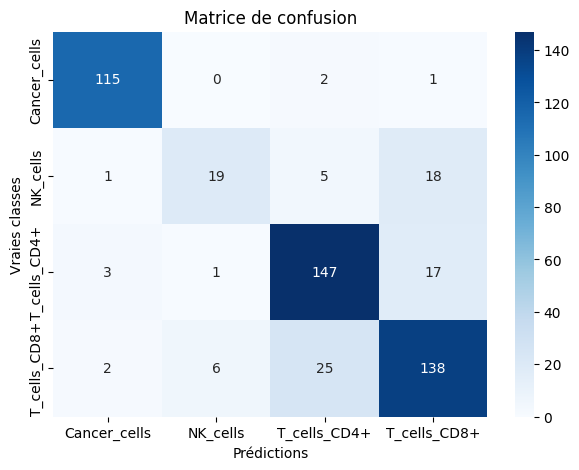

In [ ]:
cm = confusion_matrix(y_test, y_test_final, labels=["Cancer_cells","NK_cells","T_cells_CD4+","T_cells_CD8+"])

# Affichage joli avec seaborn
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Cancer_cells","NK_cells","T_cells_CD4+","T_cells_CD8+"],
            yticklabels=["Cancer_cells","NK_cells","T_cells_CD4+","T_cells_CD8+"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion")
plt.show()


## Cross-validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import numpy as np


In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# Stocker les métriques
acc_scores = []
bal_acc_scores = []

for train_index, val_index in kf.split(X_train_processed, y_train_binary):
    # Séparer train/validation
    X_tr, X_val = X_train_processed[train_index], X_train_processed[val_index]
    y_tr_bin, y_val_bin = y_train_binary[train_index], y_train_binary[val_index]
    y_tr_orig, y_val_orig = y_train_resampled[train_index], y_train_resampled[val_index]
    
    # ---- Étape 1 : modèle binaire ----
    clf_binary = RandomForestClassifier(random_state=42)
    clf_binary.fit(X_tr, y_tr_bin)
    y_val_bin_pred = clf_binary.predict(X_val)
    
    # ---- Étape 2 : modèle spécifique à chaque sous-groupe ----
    # Classe 1
    mask_tr_cl1 = y_tr_bin == "Classe_1"
    mask_val_cl1 = y_val_bin_pred == "Classe_1"
    clf_cl1 = RandomForestClassifier(random_state=42)
    clf_cl1.fit(X_tr[mask_tr_cl1], y_tr_orig[mask_tr_cl1])
    
    # Classe 2
    mask_tr_cl2 = y_tr_bin == "Classe_2"
    mask_val_cl2 = y_val_bin_pred == "Classe_2"
    clf_cl2 = RandomForestClassifier(random_state=42)
    clf_cl2.fit(X_tr[mask_tr_cl2], y_tr_orig[mask_tr_cl2])
    
    # Prédiction finale sur validation
    y_val_final = np.empty_like(y_val_bin_pred, dtype=object)
    y_val_final[mask_val_cl1] = clf_cl1.predict(X_val[mask_val_cl1])
    y_val_final[mask_val_cl2] = clf_cl2.predict(X_val[mask_val_cl2])
    
    # Calcul des métriques
    acc_scores.append(accuracy_score(y_val_orig, y_val_final))
    bal_acc_scores.append(balanced_accuracy_score(y_val_orig, y_val_final))


NameError: name 'X_train_processed' is not defined

In [ ]:
print(f"Accuracy moyen CV: {np.mean(acc_scores):.4f}")
print(f"Balanced Accuracy moyen CV: {np.mean(bal_acc_scores):.4f}")


Accuracy moyen CV: 0.9108
Balanced Accuracy moyen CV: 0.9110


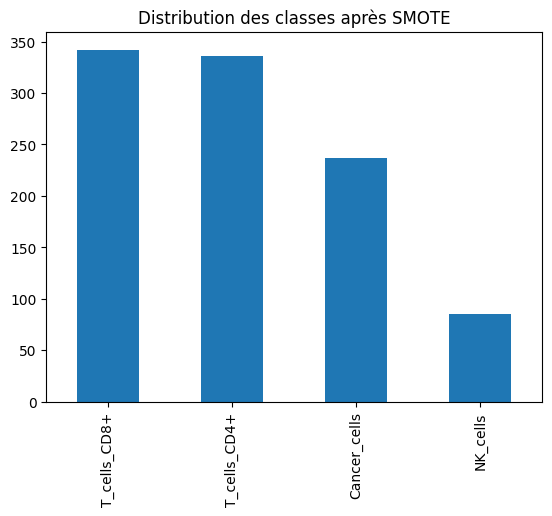

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

X_train, y_train = get_train_data(
    path="/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers"
)

#X_train, y_train = get_train_data()
X_test, y_test = get_test_data(
    path="/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers"
)

lab_df = pd.DataFrame({'label': y_train})
lab_df.value_counts(normalize=True)


pd.Series(y_train).value_counts().plot(kind='bar')
plt.title("Distribution des classes après SMOTE")
plt.show()

X_train_log = np.log1p(X_train)  # log(1 + x) sur le train
X_test_log = np.log1p(X_test)    # log(1 + x) sur le test




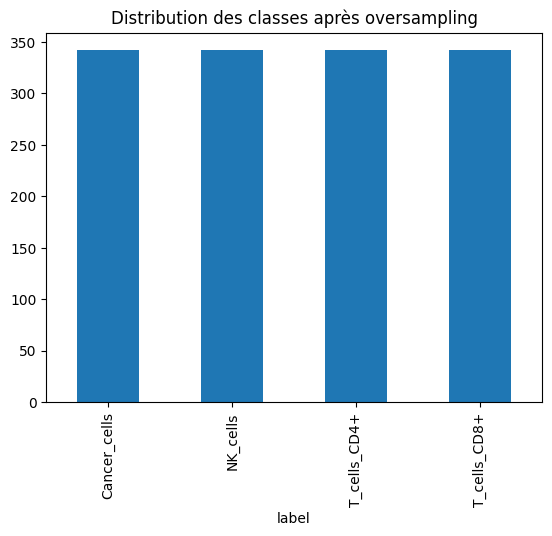

Classe Cancer_cells: 342 exemples
Classe NK_cells: 342 exemples
Classe T_cells_CD4+: 342 exemples
Classe T_cells_CD8+: 342 exemples


ValueError: setting an array element with a sequence.

In [ ]:
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# 1️⃣ Créer DataFrame combiné
df_train = pd.concat([pd.DataFrame(X_train_log), pd.Series(y_train, name='label')], axis=1)

# 2️⃣ Trouver le nombre max d'exemples (classe majoritaire)
max_count = df_train['label'].value_counts().max()

# 3️⃣ Oversampling par classe
df_list = []
for cls in df_train['label'].unique():
    df_cls = df_train[df_train['label'] == cls]
    df_cls_upsampled = resample(
        df_cls,
        replace=True,
        n_samples=max_count,
        random_state=42
    )
    df_list.append(df_cls_upsampled)

# 4️⃣ Recomposer le dataset équilibré
df_resampled = pd.concat(df_list)

# 5️⃣ Séparer X et y
X_train_resampled = df_resampled.drop(columns=['label'])
y_train_resampled = df_resampled['label']

# 6️⃣ Vérifier la distribution après oversampling
pd.Series(y_train_resampled).value_counts().plot(kind='bar')
plt.title("Distribution des classes après oversampling")
plt.show()

# 7️⃣ Afficher le nombre d'exemples par classe
unique, counts = np.unique(y_train_resampled, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Classe {cls}: {count} exemples")


X_train_resampled_dense = X_train_resampled.values.astype(float)
X_test_log_dense = X_test_log.values.astype(float) if hasattr(X_test_log, "values") else X_test_log.toarray()






In [ ]:
import numpy as np
from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# X_train_log est sparse (CSR), y_train est array

# 1️⃣ Identifier les classes
classes, counts = np.unique(y_train, return_counts=True)
max_count = counts.max()

# 2️⃣ Créer les indices oversamplés
resampled_idx = []
for cls in classes:
    idx = np.where(y_train == cls)[0]
    idx_upsampled = resample(idx, replace=True, n_samples=max_count, random_state=42)
    resampled_idx.extend(idx_upsampled)
resampled_idx = np.array(resampled_idx)

# 3️⃣ Construire X et y resamplés
X_train_resampled = X_train_log[resampled_idx]
y_train_resampled = y_train[resampled_idx]

# 4️⃣ Vérifier la distribution
unique, counts = np.unique(y_train_resampled, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Classe {cls}: {count} exemples")

# 5️⃣ Réduction de dimension adaptée aux sparse matrices
svd = TruncatedSVD(n_components=50, random_state=42)
X_train_processed = svd.fit_transform(X_train_resampled)
X_test_processed = svd.transform(X_test_log)

print("Shape après SVD :", X_train_processed.shape, X_test_processed.shape)


# Créer les labels binaires
y_train_binary = np.where(
    (y_train_resampled == "T_cell_CD8+") | (y_train_resampled == "T_cell_CD4+"),
    "Classe_1",
    "Classe_2"
)

# --- 3️⃣ Création des labels binaires via mapping explicite ---
binary_map = {
    "T_cells_CD4+": "Classe_1",
    "T_cells_CD8+": "Classe_1",
    "Cancer_cells": "Classe_2",
    "NK_cells": "Classe_2"
}
y_train_binary = np.array([binary_map[label] for label in y_train_resampled])


# Modèle binaire
clf_binary = RandomForestClassifier(random_state=42)
clf_binary.fit(X_train_processed, y_train_binary)

# Prédiction sur le test
y_test_binary_pred = clf_binary.predict(X_test_processed)


# --- 4️⃣ Modèle binaire ---
clf_binary = RandomForestClassifier(random_state=42)
clf_binary.fit(X_train_processed, y_train_binary)
y_test_binary_pred = clf_binary.predict(X_test_processed)

# --- 5️⃣ Création des sous-groupes pour les modèles spécifiques ---
# Classe 1 = T_cells
mask_cl1 = y_train_binary == "Classe_1"
X_train_cl1 = X_train_processed[mask_cl1]
y_train_cl1 = y_train_resampled[mask_cl1]  # T_cell_CD4+/CD8+

# Classe 2 = Cancer/NK
mask_cl2 = y_train_binary == "Classe_2"
X_train_cl2 = X_train_processed[mask_cl2]
y_train_cl2 = y_train_resampled[mask_cl2]  # Cancer_cells/NK_cells


# Entraînement des modèles spécifiques
clf_cl1 = RandomForestClassifier(random_state=42)
clf_cl1.fit(X_train_cl1, y_train_cl1)

clf_cl2 = RandomForestClassifier(random_state=42)
clf_cl2.fit(X_train_cl2, y_train_cl2)

# --- 6️⃣ Prédictions finales ---
y_test_final = np.empty_like(y_test_binary_pred, dtype=object)

mask_test_cl1 = y_test_binary_pred == "Classe_1"
mask_test_cl2 = y_test_binary_pred == "Classe_2"

y_test_final[mask_test_cl1] = clf_cl1.predict(X_test_processed[mask_test_cl1])
y_test_final[mask_test_cl2] = clf_cl2.predict(X_test_processed[mask_test_cl2])

# --- 7️⃣ Vérification ---
unique, counts = np.unique(y_test_final, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Classe prédite {cls}: {count} exemples")





Classe Cancer_cells: 342 exemples
Classe NK_cells: 342 exemples
Classe T_cells_CD4+: 342 exemples
Classe T_cells_CD8+: 342 exemples
Shape après SVD : (1368, 50) (500, 50)
Classe prédite Cancer_cells: 120 exemples
Classe prédite NK_cells: 28 exemples
Classe prédite T_cells_CD4+: 172 exemples
Classe prédite T_cells_CD8+: 180 exemples


In [ ]:
import numpy as np
from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# --- 1️⃣ Oversampling ---
classes, counts = np.unique(y_train, return_counts=True)
max_count = counts.max()

resampled_idx = []
for cls in classes:
    idx = np.where(y_train == cls)[0]
    idx_upsampled = resample(idx, replace=True, n_samples=max_count, random_state=42)
    resampled_idx.extend(idx_upsampled)
resampled_idx = np.array(resampled_idx)

X_train_resampled = X_train_log[resampled_idx]
y_train_resampled = y_train[resampled_idx]

# Vérification
unique, counts = np.unique(y_train_resampled, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Classe {cls}: {count} exemples")

# --- 2️⃣ Réduction de dimension ---
svd = TruncatedSVD(n_components=50, random_state=42)
X_train_processed = svd.fit_transform(X_train_resampled)
X_test_processed = svd.transform(X_test_log)

print("Shape après SVD :", X_train_processed.shape, X_test_processed.shape)

# --- 3️⃣ Création des labels binaires ---
binary_map = {
    "T_cells_CD4+": "Classe_1",
    "T_cells_CD8+": "Classe_1",
    "Cancer_cells": "Classe_2",
    "NK_cells": "Classe_2"
}
y_train_binary = np.array([binary_map[label] for label in y_train_resampled])

# --- 4️⃣ Modèle binaire ---
clf_binary = RandomForestClassifier(random_state=42)
clf_binary.fit(X_train_processed, y_train_binary)
y_test_binary_pred = clf_binary.predict(X_test_processed)

# --- 5️⃣ Modèles spécifiques ---
mask_cl1 = y_train_binary == "Classe_1"
X_train_cl1 = X_train_processed[mask_cl1]
y_train_cl1 = y_train_resampled[mask_cl1]  # T_cells

mask_cl2 = y_train_binary == "Classe_2"
X_train_cl2 = X_train_processed[mask_cl2]
y_train_cl2 = y_train_resampled[mask_cl2]  # Cancer/NK

clf_cl1 = RandomForestClassifier(random_state=42)
clf_cl1.fit(X_train_cl1, y_train_cl1)

clf_cl2 = RandomForestClassifier(random_state=42)
clf_cl2.fit(X_train_cl2, y_train_cl2)

# --- 6️⃣ Prédictions finales ---
y_test_final = np.empty_like(y_test_binary_pred, dtype=object)

mask_test_cl1 = y_test_binary_pred == "Classe_1"
mask_test_cl2 = y_test_binary_pred == "Classe_2"

y_test_final[mask_test_cl1] = clf_cl1.predict(X_test_processed[mask_test_cl1])
y_test_final[mask_test_cl2] = clf_cl2.predict(X_test_processed[mask_test_cl2])

# --- 7️⃣ Vérifications ---
unique, counts = np.unique(y_test_final, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Classe prédite {cls}: {count} exemples")

# --- 8️⃣ Metrics ---
acc = accuracy_score(y_test, y_test_final)
bal_acc = balanced_accuracy_score(y_test, y_test_final)
cm = confusion_matrix(y_test, y_test_final, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

print(f"\nAccuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")

# Affichage de la matrice de confusion
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()


NameError: name 'y_train' is not defined

Fold 1: Accuracy=0.9964, Balanced Accuracy=0.9964
Fold 2: Accuracy=0.9927, Balanced Accuracy=0.9927
Fold 3: Accuracy=0.9708, Balanced Accuracy=0.9708
Fold 4: Accuracy=0.9890, Balanced Accuracy=0.9890
Fold 5: Accuracy=0.9817, Balanced Accuracy=0.9817

Mean Accuracy: 0.9861
Mean Balanced Accuracy: 0.9861

Test Accuracy: 0.8460
Test Balanced Accuracy: 0.7971


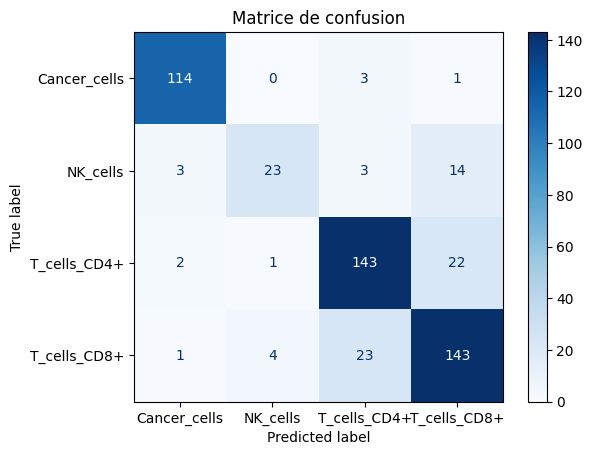

In [ ]:
import numpy as np
from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# --- Paramètres ---
n_splits = 5  # k-fold
random_state = 42

# --- 1️⃣ Oversampling ---
classes, counts = np.unique(y_train, return_counts=True)
max_count = counts.max()

resampled_idx = []
for cls in classes:
    idx = np.where(y_train == cls)[0]
    idx_upsampled = resample(idx, replace=True, n_samples=max_count, random_state=random_state)
    resampled_idx.extend(idx_upsampled)
resampled_idx = np.array(resampled_idx)

X_train_resampled = X_train_log[resampled_idx]
y_train_resampled = y_train[resampled_idx]

# --- 2️⃣ Réduction de dimension ---
svd = TruncatedSVD(n_components=50, random_state=random_state)
X_train_processed = svd.fit_transform(X_train_resampled)
X_test_processed = svd.transform(X_test_log)

# --- 3️⃣ Labels binaires ---
binary_map = {
    "T_cells_CD4+": "Classe_1",
    "T_cells_CD8+": "Classe_1",
    "Cancer_cells": "Classe_2",
    "NK_cells": "Classe_2"
}
y_train_binary = np.array([binary_map[label] for label in y_train_resampled])

# --- 4️⃣ Stratified K-Fold Cross-Validation ---
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

acc_scores = []
bal_acc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_processed, y_train_binary), 1):
    # Split train/validation
    X_tr, X_val = X_train_processed[train_idx], X_train_processed[val_idx]
    y_tr, y_val = y_train_binary[train_idx], y_train_binary[val_idx]

    # Modèle binaire
    clf_binary = RandomForestClassifier(random_state=random_state)
    clf_binary.fit(X_tr, y_tr)
    y_val_pred = clf_binary.predict(X_val)

    # Metrics sur la validation
    acc_scores.append(accuracy_score(y_val, y_val_pred))
    bal_acc_scores.append(balanced_accuracy_score(y_val, y_val_pred))
    print(f"Fold {fold}: Accuracy={acc_scores[-1]:.4f}, Balanced Accuracy={bal_acc_scores[-1]:.4f}")

print(f"\nMean Accuracy: {np.mean(acc_scores):.4f}")
print(f"Mean Balanced Accuracy: {np.mean(bal_acc_scores):.4f}")

# --- 5️⃣ Réentraînement sur tout le train et prédiction finale sur test ---
clf_binary_final = RandomForestClassifier(random_state=random_state)
clf_binary_final.fit(X_train_processed, y_train_binary)
y_test_binary_pred = clf_binary_final.predict(X_test_processed)

# Sous-modèles pour chaque groupe
mask_cl1 = y_train_binary == "Classe_1"
X_train_cl1 = X_train_processed[mask_cl1]
y_train_cl1 = y_train_resampled[mask_cl1]

mask_cl2 = y_train_binary == "Classe_2"
X_train_cl2 = X_train_processed[mask_cl2]
y_train_cl2 = y_train_resampled[mask_cl2]

clf_cl1 = RandomForestClassifier(random_state=random_state)
clf_cl1.fit(X_train_cl1, y_train_cl1)

clf_cl2 = RandomForestClassifier(random_state=random_state)
clf_cl2.fit(X_train_cl2, y_train_cl2)

# --- 6️⃣ Prédictions finales ---
y_test_final = np.empty_like(y_test_binary_pred, dtype=object)
mask_test_cl1 = y_test_binary_pred == "Classe_1"
mask_test_cl2 = y_test_binary_pred == "Classe_2"

y_test_final[mask_test_cl1] = clf_cl1.predict(X_test_processed[mask_test_cl1])
y_test_final[mask_test_cl2] = clf_cl2.predict(X_test_processed[mask_test_cl2])

# --- 7️⃣ Metrics finales ---
acc = accuracy_score(y_test, y_test_final)
bal_acc = balanced_accuracy_score(y_test, y_test_final)
cm = confusion_matrix(y_test, y_test_final, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test Balanced Accuracy: {bal_acc:.4f}")
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()


Fold 1: Accuracy=0.8212, Balanced Accuracy=0.8212
Fold 2: Accuracy=0.9088, Balanced Accuracy=0.9088
Fold 3: Accuracy=0.8577, Balanced Accuracy=0.8577
Fold 4: Accuracy=0.8864, Balanced Accuracy=0.8868
Fold 5: Accuracy=0.8608, Balanced Accuracy=0.8603

Mean Accuracy: 0.8670
Mean Balanced Accuracy: 0.8669

Test Accuracy: 0.5640
Test Balanced Accuracy: 0.4356


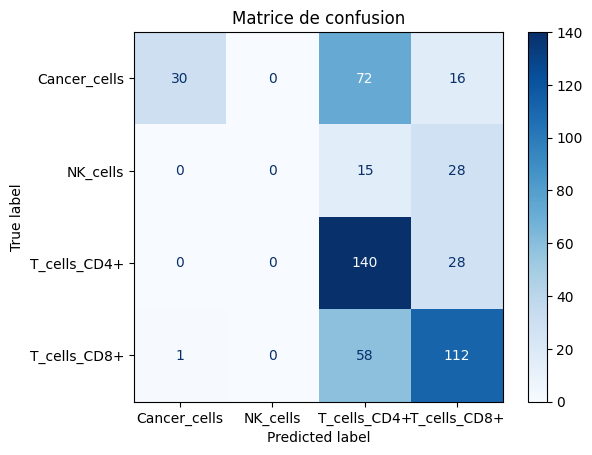

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.utils import resample

# --- 1️⃣ Prétraitement ---
def _preprocess_X(X_sparse):
    """Convertir sparse CSR en dense et normaliser chaque ligne"""
    X = X_sparse.toarray()
    return X / X.sum(axis=1)[:, np.newaxis]

# --- 2️⃣ Définition de la classe Classifier ---
class Classifier(object):
    def __init__(self, n_components=50, max_depth=5, n_estimators=100, max_features=3, random_state=42):
        self.pipe = make_pipeline(
            StandardScaler(with_mean=True, with_std=True),
            PCA(n_components=n_components, random_state=random_state),
            RandomForestClassifier(
                max_depth=max_depth, n_estimators=n_estimators, max_features=max_features, random_state=random_state
            ),
        )

    def fit(self, X_sparse, y):
        X = _preprocess_X(X_sparse)
        self.pipe.fit(X, y)

    def predict(self, X_sparse):
        X = _preprocess_X(X_sparse)
        return self.pipe.predict(X)

    def predict_proba(self, X_sparse):
        X = _preprocess_X(X_sparse)
        return self.pipe.predict_proba(X)

# --- 3️⃣ Oversampling du train ---
classes, counts = np.unique(y_train, return_counts=True)
max_count = counts.max()
resampled_idx = []
for cls in classes:
    idx = np.where(y_train == cls)[0]
    idx_upsampled = resample(idx, replace=True, n_samples=max_count, random_state=42)
    resampled_idx.extend(idx_upsampled)
resampled_idx = np.array(resampled_idx)

X_train_resampled = X_train_log[resampled_idx]
y_train_resampled = y_train[resampled_idx]

# --- 4️⃣ Labels binaires ---
binary_map = {
    "T_cells_CD4+": "Classe_1",
    "T_cells_CD8+": "Classe_1",
    "Cancer_cells": "Classe_2",
    "NK_cells": "Classe_2"
}
y_train_binary = np.array([binary_map[label] for label in y_train_resampled])

# --- 5️⃣ Stratified K-Fold ---
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
acc_scores = []
bal_acc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_resampled, y_train_binary), 1):
    X_tr, X_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
    y_tr, y_val = y_train_binary[train_idx], y_train_binary[val_idx]

    clf_binary = Classifier(n_components=500)
    clf_binary.fit(X_tr, y_tr)
    y_val_pred = clf_binary.predict(X_val)

    acc_scores.append(accuracy_score(y_val, y_val_pred))
    bal_acc_scores.append(balanced_accuracy_score(y_val, y_val_pred))
    print(f"Fold {fold}: Accuracy={acc_scores[-1]:.4f}, Balanced Accuracy={bal_acc_scores[-1]:.4f}")

print(f"\nMean Accuracy: {np.mean(acc_scores):.4f}")
print(f"Mean Balanced Accuracy: {np.mean(bal_acc_scores):.4f}")

# --- 6️⃣ Entraînement final sur tout le train ---
clf_binary_final = Classifier(n_components=500)
clf_binary_final.fit(X_train_resampled, y_train_binary)
y_test_binary_pred = clf_binary_final.predict(X_test_log)

# --- 7️⃣ Sous-modèles par groupe ---
mask_cl1 = y_train_binary == "Classe_1"
mask_cl2 = y_train_binary == "Classe_2"

X_train_cl1 = X_train_resampled[mask_cl1]
y_train_cl1 = y_train_resampled[mask_cl1]

X_train_cl2 = X_train_resampled[mask_cl2]
y_train_cl2 = y_train_resampled[mask_cl2]

clf_cl1 = Classifier(n_components=50)
clf_cl1.fit(X_train_cl1, y_train_cl1)

clf_cl2 = Classifier(n_components=50)
clf_cl2.fit(X_train_cl2, y_train_cl2)

# --- 8️⃣ Prédictions finales sur test ---
y_test_final = np.empty_like(y_test_binary_pred, dtype=object)
mask_test_cl1 = y_test_binary_pred == "Classe_1"
mask_test_cl2 = y_test_binary_pred == "Classe_2"

y_test_final[mask_test_cl1] = clf_cl1.predict(X_test_log[mask_test_cl1])
y_test_final[mask_test_cl2] = clf_cl2.predict(X_test_log[mask_test_cl2])

# --- 9️⃣ Metrics finales ---
acc = accuracy_score(y_test, y_test_final)
bal_acc = balanced_accuracy_score(y_test, y_test_final)
cm = confusion_matrix(y_test, y_test_final, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test Balanced Accuracy: {bal_acc:.4f}")

disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
import matplotlib.pyplot as plt


def preprocess_X(X_sparse):
    """
    Convertir un tableau sparse en dense et normaliser chaque ligne.
    """
    X = X_sparse.toarray()
    return X / X.sum(axis=1)[:, np.newaxis]


class Classifier:
    def __init__(self, n_components=50, max_depth=5, n_estimators=100, max_features=3, random_state=42):
        self.pipe = make_pipeline(
            StandardScaler(),
            PCA(n_components=n_components, random_state=random_state),
            RandomForestClassifier(
                max_depth=max_depth, n_estimators=n_estimators, 
                max_features=max_features, random_state=random_state
            )
        )
        
    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        
    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict(X)
    
    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict_proba(X)


def oversample(X, y, random_state=42):
    classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    resampled_idx = []
    for cls in classes:
        idx = np.where(y == cls)[0]
        idx_resampled = resample(idx, replace=True, n_samples=max_count, random_state=random_state)
        resampled_idx.extend(idx_resampled)
    resampled_idx = np.array(resampled_idx)
    return X[resampled_idx], y[resampled_idx]


def binarize_labels(y, mapping):
    return np.array([mapping[label] for label in y])


def stratified_cv(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    acc_scores = []
    bal_acc_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        clf = Classifier(n_components=50)
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)

        acc_scores.append(accuracy_score(y_val, y_pred))
        bal_acc_scores.append(balanced_accuracy_score(y_val, y_pred))
        print(f"Fold {fold}: Accuracy={acc_scores[-1]:.4f}, Balanced Accuracy={bal_acc_scores[-1]:.4f}")
    return np.mean(acc_scores), np.mean(bal_acc_scores)


def train_final_classifier(X, y, n_components=50):
    clf = Classifier(n_components=n_components)
    clf.fit(X, y)
    return clf


def train_group_classifiers(X, y_binary, y_original, n_components=50):
    classifiers = {}
    for group in np.unique(y_binary):
        mask = y_binary == group
        clf = Classifier(n_components=n_components)
        clf.fit(X[mask], y_original[mask])
        classifiers[group] = clf
    return classifiers


def predict_final(X_test, clf_binary, classifiers_group):
    y_test_binary_pred = clf_binary.predict(X_test)
    y_test_final = np.empty_like(y_test_binary_pred, dtype=object)
    for group, clf in classifiers_group.items():
        mask = y_test_binary_pred == group
        y_test_final[mask] = clf.predict(X_test[mask])
    return y_test_final




In [ ]:
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# --- 1️⃣ Fonctions utilitaires ---

def log_normalize(X):
    """Log-normalisation type log1p sur les données"""
    X = X.toarray() if hasattr(X, "toarray") else X
    return np.log1p(1 + X)

def oversample(X, y, random_state=42):
    """Oversampling pour équilibrer les classes"""
    classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    resampled_idx = []
    for cls in classes:
        idx = np.where(y == cls)[0]
        idx_resampled = resample(idx, replace=True, n_samples=max_count, random_state=random_state)
        resampled_idx.extend(idx_resampled)
    resampled_idx = np.array(resampled_idx)
    return X[resampled_idx], y[resampled_idx]

# --- 2️⃣ Classe Classifier ---

class Classifier:
    """
    Classifier avec oversampling, log-normalisation, PCA/TruncatedSVD,
    double classification (binaire puis sous-classes)
    """
    def __init__(self, n_components=50, max_depth=None, n_estimators=100,
                 max_features='sqrt', random_state=42):
        self.n_components = n_components
        self.random_state = random_state
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.max_features = max_features

        # Modèle binaire (classe regroupée)
        self.clf_binary = make_pipeline(
            FunctionTransformer(log_normalize, validate=False),
            TruncatedSVD(n_components=self.n_components, random_state=self.random_state),
            RandomForestClassifier(
                n_estimators=self.n_estimators,
                max_depth=self.max_depth,
                max_features=self.max_features,
                random_state=self.random_state
            )
        )

        # Sous-modèles pour chaque groupe
        self.group_classifiers = {}

    def fit(self, X, y, binary_map):
        """
        X : tableau numpy ou sparse
        y : labels originaux
        binary_map : dict pour regrouper les classes en binaire
        """
        # 1️⃣ Oversampling
        X_res, y_res = oversample(X, y, random_state=self.random_state)

        # 2️⃣ Création des labels binaires
        y_binary = np.array([binary_map[label] for label in y_res])

        # 3️⃣ Entraînement du modèle binaire
        self.clf_binary.fit(X_res, y_binary)

        # 4️⃣ Entraînement des sous-modèles pour chaque groupe
        for group in np.unique(y_binary):
            mask = y_binary == group
            clf = make_pipeline(
                FunctionTransformer(log_normalize, validate=False),
                TruncatedSVD(n_components=self.n_components, random_state=self.random_state),
                RandomForestClassifier(
                    n_estimators=self.n_estimators,
                    max_depth=self.max_depth,
                    max_features=self.max_features,
                    random_state=self.random_state
                )
            )
            clf.fit(X_res[mask], y_res[mask])
            self.group_classifiers[group] = clf

    def predict(self, X):
        """
        Prédiction finale après double classification
        """
        # 1️⃣ Prédiction binaire
        y_binary_pred = self.clf_binary.predict(X)

        # 2️⃣ Prédiction des sous-classes
        y_final = np.empty_like(y_binary_pred, dtype=object)
        for group, clf in self.group_classifiers.items():
            mask = y_binary_pred == group
            y_final[mask] = clf.predict(X[mask])
        return y_final

    def predict_proba(self, X):
        """
        Probabilités finales (optionnel)
        """
        y_binary_pred = self.clf_binary.predict(X)
        y_proba = np.zeros((X.shape[0], len(np.unique(y_binary_pred))))
        for i, group in enumerate(np.unique(y_binary_pred)):
            mask = y_binary_pred == group
            y_proba[mask, i] = self.group_classifiers[group].predict_proba(X[mask])[:, 1]  # colonne 1
        return y_proba


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score

# --- Paramètres ---
n_splits = 5
random_state = 42

# Exemple de binary_map pour regroupement des classes
binary_map = {
    "T_cells_CD4+": "Classe_1",
    "T_cells_CD8+": "Classe_1",
    "Cancer_cells": "Classe_2",
    "NK_cells": "Classe_2"
}

# --- Stockage des scores ---
bal_acc_scores = []

# --- Stratified K-Fold ---
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_log, y_train), 1):
    # Split train/validation
    X_tr, X_val = X_train_log[train_idx], X_train_log[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Création et entraînement du Classifier
    clf = Classifier(n_components=600, max_depth=5, n_estimators=100, max_features=3, random_state=random_state)
    clf.fit(X_tr, y_tr, binary_map)

    # Prédiction sur la validation
    y_val_pred = clf.predict(X_val)

    # Calcul de la balanced accuracy
    bal_acc = balanced_accuracy_score(y_val, y_val_pred)
    bal_acc_scores.append(bal_acc)
    print(f"Fold {fold}: Balanced Accuracy = {bal_acc:.4f}")

# --- Moyenne des scores ---
print(f"\nMean Balanced Accuracy: {np.mean(bal_acc_scores):.4f}")


TypeError: Classifier.fit() takes 3 positional arguments but 4 were given

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Paramètres ---
n_splits = 5
random_state = 42

# Exemple de binary_map pour regroupement des classes
binary_map = {
    "T_cells_CD4+": "Classe_1",
    "T_cells_CD8+": "Classe_1",
    "Cancer_cells": "Classe_2",
    "NK_cells": "Classe_2"
}

# --- Stockage des résultats ---
bal_acc_scores = []
y_true_all = []
y_pred_all = []

# --- Stratified K-Fold ---
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_log, y_train), 1):
    # Split train/validation
    X_tr, X_val = X_train_log[train_idx], X_train_log[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Création et entraînement du Classifier
    clf = Classifier(n_components=600, max_depth=5, n_estimators=100, max_features=3, random_state=random_state)
    clf.fit(X_tr, y_tr, binary_map)

    # Prédiction sur la validation
    y_val_pred = clf.predict(X_val)

    # Stockage pour confusion matrix globale
    y_true_all.extend(y_val)
    y_pred_all.extend(y_val_pred)

    # Calcul de la balanced accuracy pour ce fold
    bal_acc = balanced_accuracy_score(y_val, y_val_pred)
    bal_acc_scores.append(bal_acc)
    print(f"Fold {fold}: Balanced Accuracy = {bal_acc:.4f}")

# --- Moyenne des scores ---
print(f"\nMean Balanced Accuracy: {np.mean(bal_acc_scores):.4f}")

# --- Matrice de confusion globale ---
cm = confusion_matrix(y_true_all, y_pred_all, labels=np.unique(y_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion - K-Fold")
plt.show()


TypeError: Classifier.fit() takes 3 positional arguments but 4 were given

# New exploration des données

In [ ]:
import numpy as np

def preprocess_X(X):
    X = X.toarray()
    # Transformation logarithmique (log(x + 1)) pour éviter les problèmes avec les zéros
    X = np.log1p(X)
    print("Transformation logarithmique appliquée.")
    
    return X



In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

def preprocess(X, y, variance_threshold=0.80):
    """
    Prétraitement des données : transformation logarithmique, équilibrage des classes et réduction de dimension.
    """
    # 1. Log Transformation
    X = np.log1p(X)  # Applique log(x + 1)
    print("Transformation logarithmique appliquée.")
    
    # Vérification si X est une matrice sparse, et conversion en dense si nécessaire
    if hasattr(X, 'toarray'):  # Si c'est une matrice sparse (ex : csr_matrix)
        X = X.toarray()  # Conversion en matrice dense
        print("Conversion de la matrice sparse en dense effectuée.")
    
    # Convertir X et y en DataFrame/Series pour plus de flexibilité (optionnel)
    X_df = pd.DataFrame(X)
    y_df = pd.Series(y)
    
    # 2. Équilibrage des classes
    class_counts = y_df.value_counts()
    max_class_size = class_counts.max()  # Taille de la plus grande classe
    
    X_balanced = []
    y_balanced = []
    
    for label in class_counts.index:
        X_class = X_df[y_df == label]
        y_class = y_df[y_df == label]
        
        num_duplicates = max_class_size - len(X_class)
        
        if num_duplicates > 0:
            X_class_duplicated = X_class.sample(n=num_duplicates, replace=True, random_state=42)
            y_class_duplicated = y_class.sample(n=num_duplicates, replace=True, random_state=42)
            X_balanced.append(pd.concat([X_class, X_class_duplicated], axis=0))
            y_balanced.append(pd.concat([y_class, y_class_duplicated], axis=0))
        else:
            X_balanced.append(X_class)
            y_balanced.append(y_class)
    
    # Concaténer les données équilibrées
    X_balanced = pd.concat(X_balanced, axis=0)
    y_balanced = pd.concat(y_balanced, axis=0)
    
    # Mélanger les données pour éviter l'ordre des classes
    X_balanced = X_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    y_balanced = y_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print("Classes équilibrées et données mélangées.")
    
    # 3. Conversion de X_balanced en ndarray
    X_balanced = np.array(X_balanced)  # Conversion explicite en np.ndarray
    print("Conversion de X_balanced en ndarray effectuée.")
    
    # 4. PCA - Réduction de dimensionnalité avec sélection automatique du nombre de composantes
    pca = PCA()
    pca.fit(X_balanced)
    
    # Calculer la variance expliquée par chaque composante
    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    # Trouver le nombre de composantes nécessaires pour atteindre le seuil de variance
    n_components = np.argmax(explained_variance_ratio >= variance_threshold) + 1
    
    print(f"Nombre de composantes retenues pour expliquer {variance_threshold * 100}% de la variance : {n_components}")
    
    # Appliquer PCA avec le nombre de composantes sélectionné
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_balanced)
    
    print(f"Réduction de dimensionnalité effectuée avec {n_components} composantes principales.")
    
    return X_pca, y_balanced


In [ ]:

# Exemple d'utilisation avec X_train et y_train
X_train_balanced, y_train_balanced = preprocess(X_train, y_train, variance_threshold=0.80)

# Vérification des résultats
print(X_train_balanced.shape)  # La forme doit être (N, M), avec N le nombre d'exemples et M le nombre de caractéristiques
print(y_train_balanced.value_counts())  # Le nombre d'exemples pour chaque classe doit être équilibré



Transformation logarithmique appliquée.
Conversion de la matrice sparse en dense effectuée.
Classes équilibrées et données mélangées.
Conversion de X_balanced en ndarray effectuée.
Nombre de composantes retenues pour expliquer 80.0% de la variance : 255
Réduction de dimensionnalité effectuée avec 255 composantes principales.
(1368, 255)
Cancer_cells    342
NK_cells        342
T_cells_CD4+    342
T_cells_CD8+    342
Name: count, dtype: int64


## Méthode 1 : Log normalisation + ACP + augmentation de donnees + Random forest 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier


class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Log transform
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)

        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Class balancing (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()

        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]

            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)

        X_bal = np.array(X_bal)

        # PCA fitting
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)

        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values

        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = RandomForestClassifier(
            n_estimators=300,
            random_state=42,
             n_jobs=-1
)
    def fit(self, X, y):
        self.preprocessor.fit(X, y)
        self.model.fit(
            self.preprocessor.X_train_,
            self.preprocessor.y_train_
        )

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)


In [ ]:
# Initialisation du classifieur
clf = Classifier()

# Entraînement sur les données d'entraînement
clf.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)


In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score
)

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

if len(np.unique(y_test)) == 2:
    print("ROC AUC:", roc_auc_score(y_test, y_proba[:, 1]))


              precision    recall  f1-score   support

Cancer_cells       0.96      0.97      0.97       118
    NK_cells       1.00      0.23      0.38        43
T_cells_CD4+       0.82      0.90      0.86       168
T_cells_CD8+       0.77      0.83      0.80       171

    accuracy                           0.84       500
   macro avg       0.89      0.73      0.75       500
weighted avg       0.85      0.84      0.82       500

Confusion Matrix:
 [[115   0   2   1]
 [  0  10   7  26]
 [  1   0 151  16]
 [  4   0  25 142]]
Accuracy: 0.836
Balanced Accuracy: 0.7340883228139986


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score


def kfold_evaluation(X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracies = []
    balanced_accuracies = []

    fold = 1

    for train_idx, test_idx in skf.split(X, y):
        print(f"\nFold {fold}")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = Classifier()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        bal_acc = balanced_accuracy_score(y_test, y_pred)

        accuracies.append(acc)
        balanced_accuracies.append(bal_acc)

        print(f"Accuracy: {acc:.4f}")
        print(f"Balanced Accuracy: {bal_acc:.4f}")

        fold += 1

    print("\n=== Résultats globaux ===")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Mean Balanced Accuracy: {np.mean(balanced_accuracies):.4f} ± {np.std(balanced_accuracies):.4f}")

    return accuracies, balanced_accuracies


accuracies, balanced_accuracies = kfold_evaluation(X_test, y_test, n_splits=5)



Fold 1
Accuracy: 0.8200
Balanced Accuracy: 0.7247

Fold 2
Accuracy: 0.8000
Balanced Accuracy: 0.7029

Fold 3
Accuracy: 0.8000
Balanced Accuracy: 0.6587

Fold 4
Accuracy: 0.8100
Balanced Accuracy: 0.6921

Fold 5
Accuracy: 0.8800
Balanced Accuracy: 0.8266

=== Résultats globaux ===
Mean Accuracy: 0.8220 ± 0.0299
Mean Balanced Accuracy: 0.7210 ± 0.0569


## Méthode 2 : Log normalisation + ACP + augmentation + radom forest + classification en deux temps 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# On garde ton Preprocessor tel quel
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Log transform
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Class balancing (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]

            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1
        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)

# Classifier unique avec RandomForest et Preprocessor
class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        )

    def fit(self, X, y):
        self.preprocessor.fit(X, y)
        self.model.fit(
            self.preprocessor.X_train_,
            self.preprocessor.y_train_
        )

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)

# -------- HierarchicalClassifier --------
class HierarchicalClassifier:
    def __init__(self):
        self.clf_step1 = Classifier()  # Healthy vs Infected
        self.clf_step2 = Classifier()  # Viral vs Bacterial

    def fit(self, X, y):
        # STEP 1: Healthy vs Infected
        y_step1 = np.where(y == 0, 0, 1)
        self.clf_step1.fit(X, y_step1)

        # STEP 2: Viral vs Bacterial (infected only)
        infected_mask = y != 0
        X_step2 = X[infected_mask]
        y_step2 = y[infected_mask]
        y_step2 = np.where(y_step2 == 1, 0, 1)  # Viral=0, Bacterial=1

        self.clf_step2.fit(X_step2, y_step2)

    def predict(self, X):
        # STEP 1
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.zeros(len(step1_pred), dtype=int)

        # STEP 2
        infected_idx = np.where(step1_pred == 1)[0]
        if len(infected_idx) > 0:
            step2_pred = self.clf_step2.predict(X[infected_idx])
            final_pred[infected_idx] = step2_pred + 1  # Remap: 0->Viral(1),1->Bacterial(2)

        return final_pred


In [ ]:
hc = HierarchicalClassifier()
hc.fit(X_train, y_train)

y_pred = hc.predict(X_test)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)

# ---------------- Classifier ----------------
class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        )

    def fit(self, X, y):
        self.preprocessor.fit(X, y)
        self.model.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)

# ---------------- Hierarchical Classifier ----------------
class HierarchicalClassifier:
    def __init__(self):
        self.clf_step1 = Classifier()          # Step1: Group1 vs Group2
        self.clf_step2_group1 = Classifier()   # Step2: Cancer vs NK
        self.clf_step2_group2 = Classifier()   # Step2: CD4+ vs CD8+

    def fit(self, X, y):
        # Step 1: Group1 (Cancer_cells, NK_cells) vs Group2 (T_cells_CD4+, T_cells_CD8+)
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Step 2: classifier pour chaque groupe
        mask_group1 = [label in ['Cancer_cells','NK_cells'] for label in y]
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        mask_group2 = [label in ['T_cells_CD4+','T_cells_CD8+'] for label in y]
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Group1 : Cancer vs NK
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1)>0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Group2 : CD4+ vs CD8+
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2)>0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred

# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données
# X_train, y_train, X_test, y_test

# Initialisation
hier_clf = HierarchicalClassifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)



Classification Report:
              precision    recall  f1-score   support

Cancer_cells       0.85      0.98      0.91        42
    NK_cells       0.89      0.50      0.64        16
T_cells_CD4+       0.84      0.70      0.76        66
T_cells_CD8+       0.75      0.87      0.80        76

    accuracy                           0.81       200
   macro avg       0.83      0.76      0.78       200
weighted avg       0.81      0.81      0.80       200

Balanced Accuracy: 0.7603953064479381
Confusion Matrix:
 [[41  0  1  0]
 [ 1  8  0  7]
 [ 4  1 46 15]
 [ 2  0  8 66]]


## Methode 3 : acp pour chaque classification 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Log transform
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Class balancing (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)

# ---------------- Classifier ----------------
class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        )

    def fit(self, X, y):
        self.preprocessor.fit(X, y)
        self.model.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)

# ---------------- Hierarchical Classifier ----------------
class HierarchicalClassifier:
    def __init__(self):
        # Étape 1 : séparer les groupes
        self.clf_step1 = Classifier()
        # Étape 2 : classifier à l'intérieur des groupes
        self.clf_step2_group1 = Classifier()  # Cancer vs NK
        self.clf_step2_group2 = Classifier()  # CD4+ vs CD8+

    def fit(self, X, y):
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Sous-groupe 1 : Cancer vs NK
        mask_group1 = np.array([label in ['Cancer_cells','NK_cells'] for label in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Sous-groupe 2 : CD4+ vs CD8+
        mask_group2 = np.array([label in ['T_cells_CD4+','T_cells_CD8+'] for label in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred

# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données : X_train, y_train, X_test, y_test
hier_clf = HierarchicalClassifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)


Classification Report:
              precision    recall  f1-score   support

Cancer_cells       0.89      0.95      0.92        42
    NK_cells       0.80      0.50      0.62        16
T_cells_CD4+       0.87      0.71      0.78        66
T_cells_CD8+       0.75      0.89      0.81        76

    accuracy                           0.81       200
   macro avg       0.83      0.76      0.78       200
weighted avg       0.82      0.81      0.81       200

Balanced Accuracy: 0.7648097516518569
Confusion Matrix:
 [[40  0  0  2]
 [ 0  8  1  7]
 [ 3  2 47 14]
 [ 2  0  6 68]]


## Méthode 4 : grid search pour avoir les meilleur parametre 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


# ---------------- Stacking Classifier ----------------
class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        # Modèle Stacking avec plusieurs modèles de base
        self.model = StackingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
                ('svm', SVC(kernel='linear', probability=True, random_state=42))
            ],
            final_estimator=LogisticRegression()
        )

    def fit(self, X, y):
        self.preprocessor.fit(X, y)
        self.model.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)


# ---------------- Hierarchical Classifier ----------------
class HierarchicalClassifier:
    def __init__(self):
        self.clf_step1 = Classifier()          # Step1: Group1 vs Group2
        self.clf_step2_group1 = Classifier()   # Step2: Cancer vs NK
        self.clf_step2_group2 = Classifier()   # Step2: CD4+ vs CD8+

    def fit(self, X, y):
        # Step 1: Group1 (Cancer_cells, NK_cells) vs Group2 (T_cells_CD4+, T_cells_CD8+)
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Step 2: classifier pour chaque groupe
        mask_group1 = [label in ['Cancer_cells','NK_cells'] for label in y]
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        mask_group2 = [label in ['T_cells_CD4+','T_cells_CD8+'] for label in y]
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Group1 : Cancer vs NK
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1)>0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Group2 : CD4+ vs CD8+
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2)>0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred


# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données
# X_train, y_train, X_test, y_test

# Initialisation du classifieur hiérarchique avec Stacking
hier_clf = HierarchicalClassifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcul de l'accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Calcul de la balanced accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

# Matrice de confusion
cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)


NameError: name 'X_train' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, accuracy_score
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


# ---------------- Stacking Classifier ----------------
class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        # Modèle Stacking avec plusieurs modèles de base
        self.model = StackingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
                ('svm', SVC(kernel='linear', probability=True, random_state=42))
            ],
            final_estimator=LogisticRegression()
        )

    def fit(self, X, y):
        self.preprocessor.fit(X, y)
        self.model.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)


# ---------------- Classification en deux étapes ----------------
class HierarchicalClassifier:
    def __init__(self):
        self.clf_step1 = Classifier()  # Étape 1 : Groupe 1 vs Groupe 2
        self.clf_step2_group1 = Classifier()  # Étape 2 : Cancer vs NK
        self.clf_step2_group2 = Classifier()  # Étape 2 : CD4+ vs CD8+

    def fit(self, X, y):
        # Étape 1 : Séparer Groupe 1 (Cancer_cells, NK_cells) vs Groupe 2 (T_cells_CD4+, T_cells_CD8+)
        y_step1 = np.array([0 if label in ['Cancer_cells', 'NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Étape 2 : Séparer pour Groupe 1 : Cancer_cells vs NK_cells
        mask_group1 = [label in ['Cancer_cells', 'NK_cells'] for label in y]
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label == 'Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Étape 2 : Séparer pour Groupe 2 : T_cells_CD4+ vs T_cells_CD8+
        mask_group2 = [label in ['T_cells_CD4+', 'T_cells_CD8+'] for label in y]
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label == 'T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        # Étape 1 : Séparation entre les deux groupes
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""] * len(step1_pred), dtype=object)

        # Groupe 1 : Cancer_cells vs NK_cells
        idx_group1 = np.where(step1_pred == 0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p == 0 else "NK_cells" for p in pred_group1]

        # Groupe 2 : T_cells_CD4+ vs T_cells_CD8+
        idx_group2 = np.where(step1_pred == 1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p == 0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred


# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données
# X_train, y_train, X_test, y_test

# Initialisation du classifieur avec les étapes
hier_clf = HierarchicalClassifier()

# Entraînement du modèle
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcul de l'accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Calcul de la balanced accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

# Matrice de confusion
cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)


Classification Report:
              precision    recall  f1-score   support

Cancer_cells       1.00      0.99      1.00       118
    NK_cells       1.00      0.47      0.63        43
T_cells_CD4+       0.87      0.87      0.87       168
T_cells_CD8+       0.79      0.90      0.84       171

    accuracy                           0.87       500
   macro avg       0.91      0.81      0.84       500
weighted avg       0.88      0.87      0.87       500

Accuracy: 0.874
Balanced Accuracy: 0.8065685292919593
Confusion Matrix:
 [[117   0   1   0]
 [  0  20   3  20]
 [  0   0 146  22]
 [  0   0  17 154]]


## Exploration des données 

In [ ]:
import pandas as pd

print("Dimensions de X_train:", X_train.shape)
print("Dimensions de X_test:", X_test.shape)

Dimensions de X_train: (1000, 13551)
Dimensions de X_test: (500, 13551)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Si tes données sont déjà sous forme de DataFrame
X_train_df = pd.DataFrame(X_train)  # Si ce n'est pas déjà un DataFrame
y_train_df = pd.Series(y_train)  # Si y_train n'est pas encore une Series

X_train_df = pd.DataFrame(
    X_train.astype(float)
)



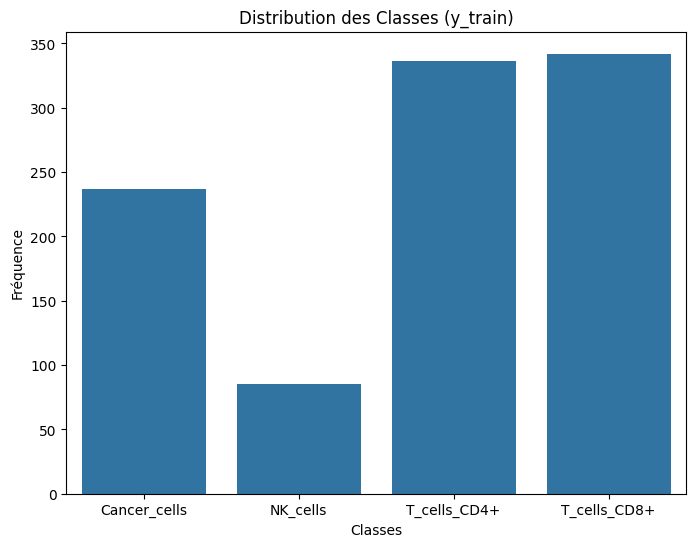

In [ ]:
# Distribution des classes (cibles)
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_df)
plt.title("Distribution des Classes (y_train)")
plt.xlabel("Classes")
plt.ylabel("Fréquence")
plt.show()


In [ ]:
import pandas as pd

# Convertir la matrice sparse en une matrice dense
X_train_dense = X_train.toarray()

# Convertir la matrice dense en DataFrame
X_train_df = pd.DataFrame(X_train_dense, columns=[f"Gene_{i}" for i in range(X_train_dense.shape[1])])

# Vérifier les types de colonnes
print(X_train_df.dtypes)


Gene_0        float32
Gene_1        float32
Gene_2        float32
Gene_3        float32
Gene_4        float32
               ...   
Gene_13546    float32
Gene_13547    float32
Gene_13548    float32
Gene_13549    float32
Gene_13550    float32
Length: 13551, dtype: object


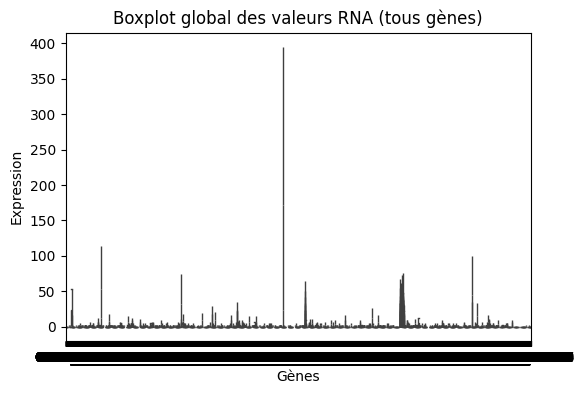

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot global des valeurs RNA (sans outliers)
plt.figure(figsize=(6, 4))
sns.boxplot(data=X_train_df, showfliers=False)  # showfliers=False pour ne pas afficher les outliers
plt.title("Boxplot global des valeurs RNA (tous gènes)")
plt.xlabel("Gènes")
plt.ylabel("Expression")
plt.show()


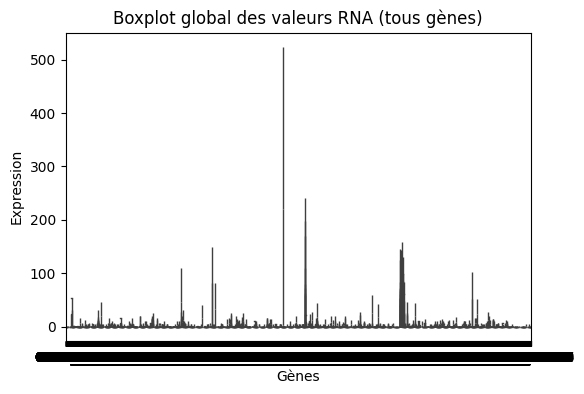

In [ ]:
# Boxplot global des valeurs RNA (sans outliers)
plt.figure(figsize=(6, 4))
sns.boxplot(data=X_train_df[X_train_df['Classe'] == 'Cancer_cells'], showfliers=False)  # showfliers=False pour ne pas afficher les outliers
plt.title("Boxplot globalcer_cells des valeurs RNA (tous gènes)")
plt.xlabel("Gènes")
plt.ylabel("Expression")
plt.show()



In [ ]:
# Sélectionner uniquement les colonnes numériques (ignorer les colonnes non numériques comme 'Classe')
X_train_numeric = X_train_df.select_dtypes(include=[float, int])

# Calcul de la variance pour ces colonnes numériques
variances = X_train_numeric.var()

# Afficher les 10 gènes avec la variance la plus faible
low_variance_genes = variances[variances < 0.01]  # Choisir un seuil comme 0.01
print("Gènes avec faible variance :", low_variance_genes)


Gènes avec faible variance : Gene_6        0.008960
Gene_20       0.005970
Gene_23       0.001998
Gene_27       0.003988
Gene_33       0.001000
                ...   
Gene_13531    0.009910
Gene_13533    0.002994
Gene_13534    0.007944
Gene_13536    0.005970
Gene_13544    0.009910
Length: 1519, dtype: float32


In [ ]:
from scipy.stats import f_oneway

# Fonction pour appliquer ANOVA à chaque gène
def anova_per_gene(df, target_column):
    p_values = []
    for gene in df.columns[:-1]:  # Ignorer la colonne 'Classe'
        groups = [df[df[target_column] == c][gene] for c in df[target_column].unique()]
        _, p_value = f_oneway(*groups)
        p_values.append(p_value)
    return pd.Series(p_values, index=df.columns[:-1])

# Ajouter la colonne des classes si ce n'est pas déjà fait
X_train_df['Classe'] = y_train_df.values

# Appliquer ANOVA pour chaque gène
p_values = anova_per_gene(X_train_df, 'Classe')

# Afficher les gènes avec des p-values non significatives (p-value > 0.05)
non_significant_genes = p_values[p_values > 0.05]
print("Gènes non discriminants :", non_significant_genes)

# Supprimer ces gènes non significatifs
X_train_df_cleaned = X_train_df.drop(columns=non_significant_genes.index)


Gènes non discriminants : Gene_6        0.295610
Gene_7        0.353112
Gene_12       0.061952
Gene_21       0.790777
Gene_23       0.146192
                ...   
Gene_13540    0.625285
Gene_13541    0.106429
Gene_13543    0.068685
Gene_13544    0.220551
Gene_13548    0.924532
Length: 3568, dtype: float64


## suppresion de gene via anova 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


# ---------------- Classifier ----------------
class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = SVC(random_state=42)

    def fit(self, X, y):
        # Appliquer le préprocesseur (PCA, normalisation, imputation)
        self.preprocessor.fit(X, y)

        # Paramètres pour GridSearchCV
        param_grid = {
            'C': [0.1, 1, 10],  # Paramètre de régularisation
            'kernel': ['linear', 'rbf'],  # Type de noyau
            'gamma': ['scale', 'auto'],  # Paramètre du noyau RBF
            'degree': [3, 4, 5]  # Degré du noyau polynomial (si applicable)
        }

        # GridSearchCV pour trouver les meilleurs hyperparamètres
        grid_search = GridSearchCV(self.model, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
        grid_search.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

        # Récupérer le meilleur modèle
        self.model = grid_search.best_estimator_
        print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)

# ---------------- Hierarchical Classifier ----------------
class HierarchicalClassifier:
    def __init__(self):
        # Étape 1 : séparer les groupes
        self.clf_step1 = Classifier()
        # Étape 2 : classifier à l'intérieur des groupes
        self.clf_step2_group1 = Classifier()  # Cancer vs NK
        self.clf_step2_group2 = Classifier()  # CD4+ vs CD8+

    def fit(self, X, y):
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Sous-groupe 1 : Cancer vs NK
        mask_group1 = np.array([label in ['Cancer_cells','NK_cells'] for label in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Sous-groupe 2 : CD4+ vs CD8+
        mask_group2 = np.array([label in ['T_cells_CD4+','T_cells_CD8+'] for label in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred



# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données : X_train, y_train, X_test, y_test
hier_clf = HierarchicalClassifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from GridSearchCV: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from GridSearchCV: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from GridSearchCV: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

Cancer_cells       1.00      0.95      0.97       118
    NK_cells       0.91      0.47      0.62        43
T_cells_CD4+       0.84      0.87      0.86       168
T_cells_CD8+       0.80      0.90      0.85       171

    accuracy                           0.86       500
   macro avg       0.89      0.80      0.82       500
weighted avg       0.87      0.86      0.86       500

Balanced Accuracy: 0.7959753089529763
Confusion Matrix:
 [[112   0   6   0]
 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


# ---------------- Classifier ----------------
class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        
        # Initialisation du modèle avec les paramètres optimaux obtenus
        self.model = SVC(C=10, kernel='rbf', gamma='scale', degree=3, random_state=42)

    def fit(self, X, y):
        # Appliquer le préprocesseur (PCA, normalisation, imputation)
        self.preprocessor.fit(X, y)

        # Entraîner le modèle
        self.model.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)


# ---------------- Hierarchical Classifier ----------------
class HierarchicalClassifier:
    def __init__(self):
        # Étape 1 : séparer les groupes
        self.clf_step1 = Classifier()
        # Étape 2 : classifier à l'intérieur des groupes
        self.clf_step2_group1 = Classifier()  # Cancer vs NK
        self.clf_step2_group2 = Classifier()  # CD4+ vs CD8+

    def fit(self, X, y):
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Sous-groupe 1 : Cancer vs NK
        mask_group1 = np.array([label in ['Cancer_cells','NK_cells'] for label in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Sous-groupe 2 : CD4+ vs CD8+
        mask_group2 = np.array([label in ['T_cells_CD4+','T_cells_CD8+'] for label in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


# ---------------- Classifier ----------------
class HClassifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = SVC(random_state=42)

    def fit(self, X, y):
        # Appliquer le préprocesseur (PCA, normalisation, imputation)
        self.preprocessor.fit(X, y)

        # Paramètres pour GridSearchCV
        param_grid = {
            'C': [0.1, 1, 10],  # Paramètre de régularisation
            'kernel': ['linear', 'rbf'],  # Type de noyau
            'gamma': ['scale', 'auto'],  # Paramètre du noyau RBF
            'degree': [3, 4, 5]  # Degré du noyau polynomial (si applicable)
        }

        # GridSearchCV pour trouver les meilleurs hyperparamètres
        grid_search = GridSearchCV(self.model, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
        grid_search.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

        # Récupérer le meilleur modèle
        self.model = grid_search.best_estimator_
        print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)

# ---------------- Hierarchical Classifier ----------------
class Classifier:
    def __init__(self):
        # Étape 1 : séparer les groupes
        self.clf_step1 = HClassifier()
        # Étape 2 : classifier à l'intérieur des groupes
        self.clf_step2_group1 = HClassifier()  # Cancer vs NK
        self.clf_step2_group2 = HClassifier()  # CD4+ vs CD8+

    def fit(self, X, y):
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Sous-groupe 1 : Cancer vs NK
        mask_group1 = np.array([label in ['Cancer_cells','NK_cells'] for label in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Sous-groupe 2 : CD4+ vs CD8+
        mask_group2 = np.array([label in ['T_cells_CD4+','T_cells_CD8+'] for label in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred



# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données : X_train, y_train, X_test, y_test
hier_clf = Classifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)



Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from GridSearchCV: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from GridSearchCV: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from GridSearchCV: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

Cancer_cells       1.00      0.98      0.99       118
    NK_cells       0.89      0.56      0.69        43
T_cells_CD4+       0.84      0.87      0.86       168
T_cells_CD8+       0.80      0.87      0.83       171

    accuracy                           0.87       500
   macro avg       0.88      0.82      0.84       500
weighted avg       0.87      0.87      0.87       500

Balanced Accuracy: 0.8189337693530898
Confusion Matrix:
 [[116   0   

In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


# ---------------- Classifier ----------------
class Classifier(object):
    def __init__(self):
        self.le = LabelEncoder()
        self.kept_idx = None  # indices des gènes conservés

        # Base estimators pour StackingClassifier
        rf = RandomForestClassifier(n_estimators=200, max_depth=50,
                                    max_features="sqrt",
                                    random_state=42)
        svc = SVC(kernel="rbf", probability=True, C=1.0, gamma="scale",
                  random_state=42)
        knn = KNeighborsClassifier(n_neighbors=15)

        stack = StackingClassifier(
            estimators=[("rf", rf), ("svc", svc), ("knn", knn)],
            final_estimator=LogisticRegression(max_iter=10000, solver="lbfgs"),
            n_jobs=-1,
            passthrough=False
        )

        # Pipeline avec prétraitement PCA et StackingClassifier
        self.pipe = make_pipeline(
            PCA(n_components=60, random_state=42),
            stack
        )

    def _preprocess_X(self, X, fit=False):
        # Supprimer les gènes peu variables
        if fit:
            X_filtered, self.kept_idx = remove_genes(X, threshold=0.01)
        else:
            # Appliquer le même masque que pour le train
            if self.kept_idx is None:
                raise ValueError("Kept indices are not set.")
            if hasattr(X, "toarray"):
                X = X.toarray()
            X_filtered = X[:, self.kept_idx]

        # Normalisation par taille de bibliothèque et log1p
        if hasattr(X_filtered, "toarray"):
            X_filtered = X_filtered.toarray()
        libsize = X_filtered.sum(axis=1)[:, None]
        libsize[libsize == 0] = 1
        X_processed = np.log1p(X_filtered / libsize * 1e4)
        return X_processed

    def fit(self, X_sparse, y):
        X = self._preprocess_X(X_sparse, fit=True)
        y_enc = self.le.fit_transform(y)
        self.pipe.fit(X, y_enc)
        self.classes_ = self.le.classes_

    def predict(self, X_sparse):
        X = self._preprocess_X(X_sparse, fit=False)
        return self.pipe.predict(X)

    def predict_proba(self, X_sparse):
        X = self._preprocess_X(X_sparse, fit=False)
        return self.pipe.predict_proba(X)


# ---------------- Hierarchical Classifier ----------------
class HierarchicalClassifier:
    def __init__(self):
        # Étape 1 : séparer les groupes
        self.clf_step1 = Classifier()
        # Étape 2 : classifier à l'intérieur des groupes
        self.clf_step2_group1 = Classifier()  # Cancer vs NK
        self.clf_step2_group2 = Classifier()  # CD4+ vs CD8+

    def fit(self, X, y):
        y_step1 = np.array([0 if label in ['Cancer_cells', 'NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Sous-groupe 1 : Cancer vs NK
        mask_group1 = np.array([label in ['Cancer_cells', 'NK_cells'] for label in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label == 'Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Sous-groupe 2 : CD4+ vs CD8+
        mask_group2 = np.array([label in ['T_cells_CD4+', 'T_cells_CD8+'] for label in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label == 'T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""] * len(step1_pred), dtype=object)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred == 0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p == 0 else "NK_cells" for p in pred_group1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred == 1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p == 0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred

    def predict_proba(self, X):
        step1_pred_proba = self.clf_step1.predict_proba(X)
        final_pred_proba = np.zeros_like(step1_pred_proba, dtype=float)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred_proba[:, 0] > 0)[0]
        if len(idx_group1) > 0:
            pred_group1_proba = self.clf_step2_group1.predict_proba(X[idx_group1])
            final_pred_proba[idx_group1] = pred_group1_proba

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred_proba[:, 1] > 0)[0]
        if len(idx_group2) > 0:
            pred_group2_proba = self.clf_step2_group2.predict_proba(X[idx_group2])
            final_pred_proba[idx_group2] = pred_group2_proba

        return final_pred_proba


In [4]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


# ---------------- Classifier ----------------
class HClassifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = SVC(random_state=42, probability=True)  

    def fit(self, X, y):
        # Appliquer le préprocesseur (PCA, normalisation, imputation)
        self.preprocessor.fit(X, y)

        # Paramètres pour GridSearchCV
        param_grid = {
            'C': [0.1, 1, 10],  # Paramètre de régularisation
            'kernel': ['linear', 'rbf'],  # Type de noyau
            'gamma': ['scale', 'auto'],  # Paramètre du noyau RBF
            'degree': [3, 4, 5]  # Degré du noyau polynomial (si applicable)
        }

        # GridSearchCV pour trouver les meilleurs hyperparamètres
        grid_search = GridSearchCV(self.model, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
        grid_search.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

        # Récupérer le meilleur modèle
        self.model = grid_search.best_estimator_
        print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)


# ---------------- Hierarchical Classifier ----------------
class Classifier:
    def __init__(self):
        # Étape 1 : séparer les groupes
        self.clf_step1 = HClassifier()
        # Étape 2 : classifier à l'intérieur des groupes
        self.clf_step2_group1 = HClassifier()  # Cancer vs NK
        self.clf_step2_group2 = HClassifier()  # CD4+ vs CD8+

    def fit(self, X, y):
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Sous-groupe 1 : Cancer vs NK
        mask_group1 = np.array([label in ['Cancer_cells','NK_cells'] for label in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Sous-groupe 2 : CD4+ vs CD8+
        mask_group2 = np.array([label in ['T_cells_CD4+','T_cells_CD8+'] for label in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred

    def predict_proba(self, X):
        # Probabilités pour la première étape
        step1_prob = self.clf_step1.predict_proba(X)
        final_prob = np.zeros((len(X), 4))  # Probabilités pour 4 classes

        # Sous-groupe 1
        idx_group1 = np.where(step1_prob[:, 0] > step1_prob[:, 1])[0]
        if len(idx_group1) > 0:
            prob_group1 = self.clf_step2_group1.predict_proba(X[idx_group1])
            final_prob[idx_group1, 0] = prob_group1[:, 0]
            final_prob[idx_group1, 1] = prob_group1[:, 1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_prob[:, 1] > step1_prob[:, 0])[0]
        if len(idx_group2) > 0:
            prob_group2 = self.clf_step2_group2.predict_proba(X[idx_group2])
            final_prob[idx_group2, 2] = prob_group2[:, 0]
            final_prob[idx_group2, 3] = prob_group2[:, 1]

        return final_prob


# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données : X_train, y_train, X_test, y_test
hier_clf = Classifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)


KeyboardInterrupt: 

## Régression logistique 

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    confusion_matrix)


import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# ---------------- Preprocessing RNA-seq avec oversampling ----------------
class Preprocessor:
    def __init__(self):
        self.X_train_ = None
        self.y_train_ = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        self.X_train_ = np.array(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X = X / (X.sum(axis=1, keepdims=True) + 1e-8)
        return X

# ---------------- Classifier ----------------
class Classifier(object):
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(score_func=f_classif, k=2000)),  # ajustable
            ("clf", LogisticRegression(
                penalty="l1",
                solver="saga",
                C=1.0,
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])

    def fit(self, X_sparse, y):
        # Appliquer le préprocesseur (log + oversampling)
        self.preprocessor.fit(X_sparse, y)
        X_train = self.preprocessor.X_train_
        y_train = self.preprocessor.y_train_
        self.pipe.fit(X_train, y_train)
        return self

    def predict(self, X_sparse):
        X = self.preprocessor.transform(X_sparse)
        return self.pipe.predict(X)

    def predict_proba(self, X_sparse):
        X = self.preprocessor.transform(X_sparse)
        return self.pipe.predict_proba(X)
    




In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix

# ---------------- Preprocessing RNA-seq avec oversampling ----------------
class Preprocessor:
    def __init__(self):
        self.X_train_ = None
        self.y_train_ = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        self.X_train_ = np.array(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return X

# ---------------- Classifier multinomial ----------------
class Classifier(object):
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.pipe = Pipeline([
            
            ("select", SelectKBest(score_func=f_classif, k=4000)),  # ajustable
            ("clf", LogisticRegression(
                penalty="l2",
                solver="saga",
                multi_class="multinomial",  
                C=1.0,
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])

    def fit(self, X_sparse, y):
        self.preprocessor.fit(X_sparse, y)
        X_train = self.preprocessor.X_train_
        y_train = self.preprocessor.y_train_
        self.pipe.fit(X_train, y_train)
        return self

    def predict(self, X_sparse):
        X = self.preprocessor.transform(X_sparse)
        return self.pipe.predict(X)

    def predict_proba(self, X_sparse):
        X = self.preprocessor.transform(X_sparse)
        return self.pipe.predict_proba(X)

# ---------------- Exemple d'utilisation ----------------
# clf = Classifier()
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# y_proba = clf.predict_proba(X_test)
# print(classification_report(y_test, y_pred))


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

# ---------------- Preprocessor avec oversampling, sans PCA ----------------
class Preprocessor:
    def fit(self, X, y):
        """
        Transformation log1p + normalisation par cellule (library size)
        avec oversampling pour équilibrer les classes
        """
        # Convertir en dense si sparse
        X = X.toarray() if hasattr(X, "toarray") else X
        X = np.log1p(X)  # Log transformation
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Oversampling pour équilibrer les classes
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42).to_numpy()
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42).to_numpy()

        # Normalisation par cellule
        X_bal = X_bal / (X_bal.sum(axis=1, keepdims=True) + 1e-8)

        self.X_train_ = X_bal
        self.y_train_ = y_bal
        return self

    def transform(self, X):
        X = X.toarray() if hasattr(X, "toarray") else X
        X = np.log1p(X)
        X = X / (X.sum(axis=1, keepdims=True) + 1e-8)
        return X


# ---------------- HClassifier avec RandomForest ----------------
class HClassifier:
    def __init__(self, k_features=4000, n_estimators=500, max_depth=None):
        self.preprocessor = Preprocessor()
        self.selector = SelectKBest(score_func=f_classif, k=k_features)
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        )

    def fit(self, X, y):
        self.preprocessor.fit(X, y)
        X_train = self.preprocessor.X_train_
        y_train = self.preprocessor.y_train_

        # Sélection des features
        X_train_sel = self.selector.fit_transform(X_train, y_train)

        # Entraîner le RandomForest
        self.model.fit(X_train_sel, y_train)

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        X_proc = self.selector.transform(X_proc)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        X_proc = self.selector.transform(X_proc)
        return self.model.predict_proba(X_proc)

# ---------------- Classifier hiérarchique ----------------
class Classifier:
    def __init__(self):
        self.clf_step1 = HClassifier()
        self.clf_step2_group1 = HClassifier()
        self.clf_step2_group2 = HClassifier()

    def fit(self, X, y):
        y_step1 = np.array([0 if lbl in ['Cancer_cells','NK_cells'] else 1 for lbl in y])
        self.clf_step1.fit(X, y_step1)

        mask_group1 = np.array([lbl in ['Cancer_cells','NK_cells'] for lbl in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if lbl=='Cancer_cells' else 1 for lbl in y[mask_group1]])
        )

        mask_group2 = np.array([lbl in ['T_cells_CD4+','T_cells_CD8+'] for lbl in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if lbl=='T_cells_CD4+' else 1 for lbl in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred

    def predict_proba(self, X):
        step1_prob = self.clf_step1.predict_proba(X)
        final_prob = np.zeros((len(X), 4))  # 4 classes

        idx_group1 = np.where(step1_prob[:,0] > step1_prob[:,1])[0]
        if len(idx_group1) > 0:
            prob_group1 = self.clf_step2_group1.predict_proba(X[idx_group1])
            final_prob[idx_group1,0] = prob_group1[:,0]
            final_prob[idx_group1,1] = prob_group1[:,1]

        idx_group2 = np.where(step1_prob[:,1] >= step1_prob[:,0])[0]
        if len(idx_group2) > 0:
            prob_group2 = self.clf_step2_group2.predict_proba(X[idx_group2])
            final_prob[idx_group2,2] = prob_group2[:,0]
            final_prob[idx_group2,3] = prob_group2[:,1]

        return final_prob


In [ ]:
# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données : X_train, y_train, X_test, y_test
hier_clf = Classifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)

/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# ======================================================
# 1. PREPROCESSING RNA-seq
# ======================================================
class Preprocessor:
    def __init__(self):
        self.X_train_ = None
        self.y_train_ = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        self.X_train_ = np.array(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return X

# ======================================================
# 2. STACKING CLASSIFIER POUR SOUMISSION
# ======================================================
class Classifier(object):
    def __init__(self):
        # Base learners
        self.base_learners = [
            ('rf', RandomForestClassifier(
                n_estimators=200,
                max_depth=None,
                class_weight='balanced',
                random_state=42,
                n_jobs=-1
            )),
            ('knn', KNeighborsClassifier(
                n_neighbors=5,
                weights='distance',
                n_jobs=-1
            )),
            ('svc', SVC(
                C=1.0,
                kernel='rbf',
                gamma='scale',
                class_weight='balanced',
                probability=True,
                random_state=42
            ))
        ]

        # Meta-learner
        self.meta_learner = LogisticRegression(
            penalty='l2',
            solver='lbfgs',
            max_iter=5000,
            class_weight='balanced',
            n_jobs=-1
        )

        # Stacking classifier
        self.pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("var_thresh", VarianceThreshold(threshold=1e-4)),
            ("select", SelectKBest(score_func=f_classif, k=2000)),
            ("stack", StackingClassifier(
                estimators=self.base_learners,
                final_estimator=self.meta_learner,
                passthrough=True,
                n_jobs=-1
            ))
        ])

    def fit(self, X_sparse, y):
        X_proc = preprocess_X(X_sparse)
        self.pipe.fit(X_proc, y)
        return self

    def predict(self, X_sparse):
        X_proc = preprocess_X(X_sparse)
        return self.pipe.predict(X_proc)

    def predict_proba(self, X_sparse):
        X_proc = preprocess_X(X_sparse)
        return self.pipe.predict_proba(X_proc)

# ======================================================
# 3. CROSS-VALIDATION EXEMPLE
# ======================================================
def cross_validate_classifier(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    bal_acc_scores = []
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n===== Fold {fold}/{n_splits} =====")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        clf = Classifier()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)

        bal_acc = balanced_accuracy_score(y_val, y_pred)
        bal_acc_scores.append(bal_acc)

        print(f"Balanced accuracy (fold {fold}): {bal_acc:.4f}")

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

    print("\n==============================")
    print("GLOBAL RESULTS (ALL FOLDS)")
    print("==============================")

    print("Mean Balanced Accuracy:", np.mean(bal_acc_scores))
    print("Std Balanced Accuracy:", np.std(bal_acc_scores))

    print("\nClassification Report (global):")
    print(classification_report(all_y_true, all_y_pred))

    labels = np.unique(y)
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    print("Confusion Matrix (global):")
    print(cm)

    return bal_acc_scores

# ======================================================
# 4. UTILISATION (EXEMPLE)
# ======================================================
scores = cross_validate_classifier(X_train, y_train, n_splits=5)
clf = Classifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)



===== Fold 1/5 =====
Balanced accuracy (fold 1): 0.8313

===== Fold 2/5 =====
Balanced accuracy (fold 2): 0.8087

===== Fold 3/5 =====
Balanced accuracy (fold 3): 0.8200

===== Fold 4/5 =====
Balanced accuracy (fold 4): 0.8106

===== Fold 5/5 =====
Balanced accuracy (fold 5): 0.8438

GLOBAL RESULTS (ALL FOLDS)
Mean Balanced Accuracy: 0.8228784639002301
Std Balanced Accuracy: 0.013192594363480198

Classification Report (global):
              precision    recall  f1-score   support

Cancer_cells       0.97      0.98      0.98       237
    NK_cells       0.73      0.62      0.67        85
T_cells_CD4+       0.85      0.88      0.86       336
T_cells_CD8+       0.81      0.81      0.81       342

    accuracy                           0.86      1000
   macro avg       0.84      0.82      0.83      1000
weighted avg       0.86      0.86      0.86      1000

Confusion Matrix (global):
[[233   1   2   1]
 [  2  53   2  28]
 [  3   4 295  34]
 [  2  15  49 276]]


## Amélioration du modele de regression logistique

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    confusion_matrix)
 
 
def preprocess_X(X_sparse):
    """
    Preprocessing RNA-seq standard :
    - log1p
    - normalisation par cellule (library size)
    """
    X = X_sparse.toarray()
 
    # Log transform
    X = np.log1p(X)
 
    # Library size normalization
    X = X / (X.sum(axis=1, keepdims=True) + 1e-8)
 
    return X
 
 
class Classifier(object):
    def __init__(self):
        self.pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(
                score_func=f_classif,
                k=2000  #  à ajuster (1000–5000)
            )),
            ("clf", LogisticRegression(
                penalty="l1",
                solver="saga",
                C=1.0,
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])
 
    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        return self
 
    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict(X)
 
    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict_proba(X)
 
 

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

def preprocess_X(X_sparse):
    """
    Preprocessing RNA-seq standard :
    - log1p
    - normalisation par cellule (library size)
    """
    X = X_sparse.toarray()
    X = np.log1p(X)
    X = X / (X.sum(axis=1, keepdims=True) + 1e-8)
    return X

class TwoStepClassifier(object):
    def __init__(self):
        # Étape 1 : Cancer vs Autres
        self.pipe_step1 = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(score_func=f_classif, k=2000)),
            ("clf", LogisticRegression(
                penalty="l1",
                solver="saga",
                C=1.0,
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])
        
        # Étape 2 : Classification interne des autres cellules
        self.pipe_step2_others = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(score_func=f_classif, k=2000)),
            ("clf", LogisticRegression(
                penalty="l1",
                solver="saga",
                C=1.0,
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])

    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        
        # Création du label binaire pour l'étape 1
        y_step1 = np.array([1 if label == "Cancer_cells" else 0 for label in y])
        self.pipe_step1.fit(X, y_step1)
        
        # Étape 2 : sous-groupe des "autres cellules"
        mask_others = y_step1 == 0
        X_others = X[mask_others]
        y_others = np.array([label for label in y[mask_others]])
        self.pipe_step2_others.fit(X_others, y_others)
        
        return self

    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        step1_pred = self.pipe_step1.predict(X)
        final_pred = np.array([""] * len(X), dtype=object)
        
        # Cancer
        final_pred[step1_pred == 1] = "Cancer_cells"
        
        # Autres
        idx_others = np.where(step1_pred == 0)[0]
        if len(idx_others) > 0:
            pred_others = self.pipe_step2_others.predict(X[idx_others])
            final_pred[idx_others] = pred_others
        
        return final_pred

    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        step1_prob = self.pipe_step1.predict_proba(X)
        
        n_classes = len(np.unique(np.concatenate([["Cancer_cells"], self.pipe_step2_others.classes_])))
        final_prob = np.zeros((len(X), n_classes))
        
        # Cancer
        final_prob[:, 0] = step1_prob[:, 1]  # Probabilité Cancer
        
        # Autres
        idx_others = np.where(step1_prob[:, 0] >= step1_prob[:, 1])[0]
        if len(idx_others) > 0:
            prob_others = self.pipe_step2_others.predict_proba(X[idx_others])
            final_prob[idx_others, 1:] = prob_others
        
        return final_prob


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif


def preprocess_X(X_sparse):
    """
    Preprocessing RNA-seq standard :
    - log1p
    - normalisation par cellule (library size)
    """
    X = X_sparse.toarray()
    X = np.log1p(X)
    X = X / (X.sum(axis=1, keepdims=True) + 1e-8)
    return X

class TwoStepClassifier(object):
    def __init__(self, grid_search=False):
        self.grid_search = grid_search
        
        # Étape 1 : Cancer vs Autres
        self.pipe_step1 = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(score_func=mutual_info_classif, k=0.2)),
            ("clf", LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])
        
        # Étape 2 : Classification interne des autres cellules
        self.pipe_step2_others = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(score_func=mutual_info_classif, k=0.2)),
            ("clf", LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])
        
        # Param grid pour GridSearch
        self.param_grid = {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__l1_ratio": [0.2, 0.5, 0.8]
        }

    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        
        # Étape 1 : Cancer vs Autres
        y_step1 = np.array([1 if label == "Cancer_cells" else 0 for label in y])
        if self.grid_search:
            self.gs_step1 = GridSearchCV(
                self.pipe_step1,
                param_grid=self.param_grid,
                cv=5,
                scoring="balanced_accuracy",
                n_jobs=-1
            )
            self.gs_step1.fit(X, y_step1)
            self.pipe_step1 = self.gs_step1.best_estimator_
        else:
            self.pipe_step1.fit(X, y_step1)
        
        # Étape 2 : sous-groupe des "autres cellules"
        mask_others = y_step1 == 0
        X_others = X[mask_others]
        y_others = np.array([label for label in y[mask_others]])
        if self.grid_search:
            self.gs_step2 = GridSearchCV(
                self.pipe_step2_others,
                param_grid=self.param_grid,
                cv=5,
                scoring="balanced_accuracy",
                n_jobs=-1
            )
            self.gs_step2.fit(X_others, y_others)
            self.pipe_step2_others = self.gs_step2.best_estimator_
        else:
            self.pipe_step2_others.fit(X_others, y_others)
        
        return self

    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        step1_pred = self.pipe_step1.predict(X)
        final_pred = np.array([""] * len(X), dtype=object)
        
        # Cancer
        final_pred[step1_pred == 1] = "Cancer_cells"
        
        # Autres
        idx_others = np.where(step1_pred == 0)[0]
        if len(idx_others) > 0:
            pred_others = self.pipe_step2_others.predict(X[idx_others])
            final_pred[idx_others] = pred_others
        
        return final_pred

    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        step1_prob = self.pipe_step1.predict_proba(X)
        
        n_classes = len(np.unique(np.concatenate([["Cancer_cells"], self.pipe_step2_others.classes_])))
        final_prob = np.zeros((len(X), n_classes))
        
        # Cancer
        final_prob[:, 0] = step1_prob[:, 1]  # Probabilité Cancer
        
        # Autres
        idx_others = np.where(step1_prob[:, 0] >= step1_prob[:, 1])[0]
        if len(idx_others) > 0:
            prob_others = self.pipe_step2_others.predict_proba(X[idx_others])
            final_prob[idx_others, 1:] = prob_others
        
        return final_prob


In [ ]:
# ======================================================
# 3. CROSS-VALIDATION EXEMPLE
# ======================================================
def cross_validate_classifier(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    bal_acc_scores = []
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n===== Fold {fold}/{n_splits} =====")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        clf = Classifier()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)

        bal_acc = balanced_accuracy_score(y_val, y_pred)
        bal_acc_scores.append(bal_acc)

        print(f"Balanced accuracy (fold {fold}): {bal_acc:.4f}")

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

    print("\n==============================")
    print("GLOBAL RESULTS (ALL FOLDS)")
    print("==============================")

    print("Mean Balanced Accuracy:", np.mean(bal_acc_scores))
    print("Std Balanced Accuracy:", np.std(bal_acc_scores))

    print("\nClassification Report (global):")
    print(classification_report(all_y_true, all_y_pred))

    labels = np.unique(y)
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    print("Confusion Matrix (global):")
    print(cm)

    return bal_acc_scores

# ======================================================
# 4. UTILISATION (EXEMPLE)
# ======================================================
scores = cross_validate_classifier(X_train, y_train, n_splits=5)
clf = Classifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)



===== Fold 1/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  249   508   818  1125  1450  1580  1621  1686  2300  2402  2441  3156
  3405  3871  4050  4353  4471  4839  5547  6088  7882  7984  8088  8414
  8763  8822  9659  9693  9720 10241 10391 10541 10823 11225 11359 11417
 11430 11774 11860 12231 12270 12497 13008 13204 13247] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 1): 0.8623

===== Fold 2/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  286   515   710   845  1466  1558  1594  2607  2820  2845  3769  3865
  4112  4156  4338  4659  4906  5433  5825  5885  6006  7825  8357  9606
  9630 10125 10139 10918 11371 11608 12177 12764 12768 12819 13099] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 2): 0.8788

===== Fold 3/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   33   220   223   611  1016  1442  1606  2431  2433  2511  2594  3024
  3092  3176  3354  4166  4230  4714  5802  6775  7750  7913  8151  8712
  9592  9639  9730  9969 10047 10150 10583 10593 10840 11414 11745 13468] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 3): 0.8055

===== Fold 4/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  216   247   621   856  1370  1814  1830  2569  2827  2836  2853  3743
  4066  4361  4668  4671  4788  5286  6194  6717  7133  7476  7756  7969
  9557  9584  9610  9905 10038 10087 10370 11365 12225 12677 12684 12762
 12963 13249 13418] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 4): 0.8531

===== Fold 5/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   76  1576  1659  1664  1907  2001  2650  3101  3390  3856  4055  4510
  4513  4996  5174  5392  5607  5895  6053  6055  6098  6156  7975  8034
  8427  9201  9451  9575  9675  9687  9692 11052 11376 11602 11727 11881
 12237 12822 12872 13443] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


KeyboardInterrupt: 

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def preprocess_X(X_sparse):
    X = X_sparse.toarray()
    X = np.log1p(X)
    X = X / (X.sum(axis=1, keepdims=True) + 1e-4)
    return X

class Classifier(object):
    def __init__(self, grid_search=False):
        self.grid_search = grid_search
        
        # Étape 1 : Cancer vs NK
        self.pipe_step1 = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(score_func=mutual_info_classif, k=2000)),
            ("clf", LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])
        
        # Étape 2 : CD4 vs CD8
        self.pipe_step2_group2 = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(score_func=mutual_info_classif, k=2000)),
            ("clf", LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])
        
        # Param grid pour GridSearch
        self.param_grid = {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__l1_ratio": [0.2, 0.5, 0.8]
        }

    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        
        # --- Étape 1 : Cancer vs NK ---
        mask_group1 = np.array([label in ["Cancer_cells", "NK_cells"] for label in y])
        X_group1 = X[mask_group1]
        y_group1 = np.array([0 if label == "Cancer_cells" else 1 for label in np.array(y)[mask_group1]])

        if self.grid_search:
            gs1 = GridSearchCV(self.pipe_step1, param_grid=self.param_grid,
                               cv=5, scoring="balanced_accuracy", n_jobs=-1)
            gs1.fit(X_group1, y_group1)
            self.pipe_step1 = gs1.best_estimator_
        else:
            self.pipe_step1.fit(X_group1, y_group1)

        # --- Étape 2 : CD4 vs CD8 ---
        mask_group2 = np.array([label in ["T_cells_CD4+", "T_cells_CD8+"] for label in y])
        X_group2 = X[mask_group2]
        y_group2 = np.array([0 if label == "T_cells_CD4+" else 1 for label in np.array(y)[mask_group2]])

        if self.grid_search:
            gs2 = GridSearchCV(self.pipe_step2_group2, param_grid=self.param_grid,
                               cv=5, scoring="balanced_accuracy", n_jobs=-1)
            gs2.fit(X_group2, y_group2)
            self.pipe_step2_group2 = gs2.best_estimator_
        else:
            self.pipe_step2_group2.fit(X_group2, y_group2)

        return self

    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        final_pred = np.array([""] * len(X), dtype=object)

        # --- Étape 1 : Cancer vs NK ---
        step1_pred = self.pipe_step1.predict(X)
        final_pred[step1_pred == 0] = "Cancer_cells"
        final_pred[step1_pred == 1] = "NK_cells"

        # --- Étape 2 : CD4 vs CD8 ---
        idx_group2 = np.where(final_pred == "")[0]
        if len(idx_group2) > 0:
            pred_group2 = self.pipe_step2_group2.predict(X[idx_group2])
            for i, p in zip(idx_group2, pred_group2):
                final_pred[i] = "T_cells_CD4+" if p == 0 else "T_cells_CD8+"

        return final_pred

    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        final_prob = np.zeros((len(X), 4))  # Cancer, NK, CD4, CD8

        # Étape 1
        prob_group1 = self.pipe_step1.predict_proba(X)
        final_prob[:, 0] = prob_group1[:, 0]  # Cancer
        final_prob[:, 1] = prob_group1[:, 1]  # NK

        # Étape 2
        idx_group2 = np.where((final_prob[:, 0] + final_prob[:, 1]) < 1.0)[0]
        if len(idx_group2) > 0:
            prob_group2 = self.pipe_step2_group2.predict_proba(X[idx_group2])
            final_prob[idx_group2, 2] = prob_group2[:, 0]  # CD4
            final_prob[idx_group2, 3] = prob_group2[:, 1]  # CD8

        return final_prob


In [8]:

from sklearn.model_selection import StratifiedKFold

# ======================================================
# 3. CROSS-VALIDATION EXEMPLE
# ======================================================
def cross_validate_classifier(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    bal_acc_scores = []
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n===== Fold {fold}/{n_splits} =====")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        clf = Classifier()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)

        bal_acc = balanced_accuracy_score(y_val, y_pred)
        bal_acc_scores.append(bal_acc)

        print(f"Balanced accuracy (fold {fold}): {bal_acc:.4f}")

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

    print("\n==============================")
    print("GLOBAL RESULTS (ALL FOLDS)")
    print("==============================")

    print("Mean Balanced Accuracy:", np.mean(bal_acc_scores))
    print("Std Balanced Accuracy:", np.std(bal_acc_scores))

    print("\nClassification Report (global):")
    print(classification_report(all_y_true, all_y_pred))

    labels = np.unique(y)
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    print("Confusion Matrix (global):")
    print(cm)

    return bal_acc_scores

# ======================================================
# 4. UTILISATION (EXEMPLE)
# ======================================================
scores = cross_validate_classifier(X_train, y_train, n_splits=5)
clf = Classifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)



===== Fold 1/5 =====


ValueError: l1_ratio must be specified when penalty is elasticnet.

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    confusion_matrix)
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
 
 
def preprocess_X(X_sparse):
    """
    Preprocessing RNA-seq standard :
    - log1p
    - normalisation par cellule (library size)
    """
    X = X_sparse.toarray()
 
    # Log transform
    X = np.log1p(X)
 
    # Library size normalization
    X = X / (X.sum(axis=1, keepdims=True) + 1e-4)
 
    return X
 
 
class Classifier(object):
    def __init__(self):
        self.pipe = Pipeline([
         #   ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(
                score_func=f_classif,
                k=5500  #  à ajuster (1000–5000)
            )),
            ("clf",  RandomForestClassifier(
                 n_estimators=2500,        # nombre d'arbres
                 max_depth=None,           # profondeur illimitée
                 class_weight="balanced",  # équilibre les classes
                n_jobs=-1,                # parallélisation CPU
                random_state=42
        ))
        ])
 
    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        return self
 
    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict(X)
 
    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict_proba(X)

In [11]:
# ======================================================
# 3. CROSS-VALIDATION EXEMPLE
# ======================================================
def cross_validate_classifier(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    bal_acc_scores = []
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n===== Fold {fold}/{n_splits} =====")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        clf = Classifier()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)

        bal_acc = balanced_accuracy_score(y_val, y_pred)
        bal_acc_scores.append(bal_acc)

        print(f"Balanced accuracy (fold {fold}): {bal_acc:.4f}")

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

    print("\n==============================")
    print("GLOBAL RESULTS (ALL FOLDS)")
    print("==============================")

    print("Mean Balanced Accuracy:", np.mean(bal_acc_scores))
    print("Std Balanced Accuracy:", np.std(bal_acc_scores))

    print("\nClassification Report (global):")
    print(classification_report(all_y_true, all_y_pred))

    labels = np.unique(y)
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    print("Confusion Matrix (global):")
    print(cm)

    return bal_acc_scores

# ======================================================
# 4. UTILISATION (EXEMPLE)
# ======================================================
scores = cross_validate_classifier(X_train, y_train, n_splits=5)
clf = Classifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)



===== Fold 1/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  249   508   818  1125  1450  1580  1621  1686  2300  2402  2441  3156
  3405  3871  4050  4353  4471  4839  5547  6088  7882  7984  8088  8414
  8763  8822  9659  9693  9720 10241 10391 10541 10823 11225 11359 11417
 11430 11774 11860 12231 12270 12497 13008 13204 13247] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 1): 0.7243

===== Fold 2/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  286   515   710   845  1466  1558  1594  2607  2820  2845  3769  3865
  4112  4156  4338  4659  4906  5433  5825  5885  6006  7825  8357  9606
  9630 10125 10139 10918 11371 11608 12177 12764 12768 12819 13099] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 2): 0.7424

===== Fold 3/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   33   220   223   611  1016  1442  1606  2431  2433  2511  2594  3024
  3092  3176  3354  4166  4230  4714  5802  6775  7750  7913  8151  8712
  9592  9639  9730  9969 10047 10150 10583 10593 10840 11414 11745 13468] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 3): 0.7536

===== Fold 4/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  216   247   621   856  1370  1814  1830  2569  2827  2836  2853  3743
  4066  4361  4668  4671  4788  5286  6194  6717  7133  7476  7756  7969
  9557  9584  9610  9905 10038 10087 10370 11365 12225 12677 12684 12762
 12963 13249 13418] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 4): 0.7149

===== Fold 5/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   76  1576  1659  1664  1907  2001  2650  3101  3390  3856  4055  4510
  4513  4996  5174  5392  5607  5895  6053  6055  6098  6156  7975  8034
  8427  9201  9451  9575  9675  9687  9692 11052 11376 11602 11727 11881
 12237 12822 12872 13443] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 5): 0.7310

GLOBAL RESULTS (ALL FOLDS)
Mean Balanced Accuracy: 0.7332402485653573
Std Balanced Accuracy: 0.013577831267500168

Classification Report (global):
              precision    recall  f1-score   support

Cancer_cells       0.98      1.00      0.99       237
    NK_cells       1.00      0.15      0.27        85
T_cells_CD4+       0.92      0.86      0.89       336
T_cells_CD8+       0.73      0.93      0.82       342

    accuracy                           0.85      1000
   macro avg       0.91      0.73      0.74      1000
weighted avg       0.88      0.85      0.83      1000

Confusion Matrix (global):
[[236   0   0   1]
 [  0  13   3  69]
 [  2   0 288  46]
 [  2   0  23 317]]


In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix


def preprocess_X(X_sparse):
    """
    Preprocessing RNA-seq standard :
    - log1p
    - normalisation par cellule (library size)
    """
    X = X_sparse.toarray()
 
    # Log transform
    X = np.log1p(X)
 
    # Library size normalization
    X = X / (X.sum(axis=1, keepdims=True) + 1e-4)
 
    return X


class Classifier(object):
    def __init__(self):
        self.pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),  # Standardisation
            ("select", SelectKBest(
                score_func=f_classif,
                k=2000  # à ajuster (1000–5000)
            )),
            ("clf", BaggingClassifier(
                estimator=LogisticRegression(  # Remplace `base_estimator` par `estimator`
                    penalty="l1",
                    solver="saga",
                    C=1.0,
                    class_weight="balanced",
                    max_iter=5000,
                    n_jobs=-1
                ),
                n_estimators=50,  # Nombre d'estimateurs (régressions logistiques)
                random_state=42,
                n_jobs=-1
            ))
        ])
 
    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        return self
 
    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict(X)
 
    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict_proba(X)


In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,  VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix


def preprocess_X(X_sparse):
    """
    Preprocessing RNA-seq standard :
    - log1p
    - normalisation par cellule (library size)
    """
    X = X_sparse.toarray()
 
    # Log transform
    X = np.log1p(X)
 
    # Library size normalization
    X = X / (X.sum(axis=1, keepdims=True) + 1e-4)
 
    return X


class Classifier(object):
    def __init__(self):
        # Créer plusieurs régressions logistiques
        self.log_reg1 = LogisticRegression(
            penalty="l1",
            solver="saga",
            C=1.0,
            class_weight="balanced",
            max_iter=5000,
            n_jobs=-1
        )
        self.log_reg2 = LogisticRegression(
            penalty="l1",
            solver="saga",
            C=1.0,
            class_weight="balanced",
            max_iter=5000,
            n_jobs=-1
        )

        # Créer un classifieur de vote (ensemble)
        self.pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),  # Standardisation
            ("select", SelectKBest(
                score_func=f_classif,
                k=2000  # à ajuster (1000–5000)
            )),
            ("clf", VotingClassifier(
                estimators=[
                    ('logreg1', self.log_reg1),
                    ('logreg2', self.log_reg2)
                ],
                voting='hard'  # Utilisation du vote majoritaire
            ))
        ])
 
    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        return self
 
    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict(X)
 
    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict_proba(X)


In [15]:
# ======================================================
# 3. CROSS-VALIDATION EXEMPLE
# ======================================================
def cross_validate_classifier(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    bal_acc_scores = []
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n===== Fold {fold}/{n_splits} =====")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        clf = Classifier()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)

        bal_acc = balanced_accuracy_score(y_val, y_pred)
        bal_acc_scores.append(bal_acc)

        print(f"Balanced accuracy (fold {fold}): {bal_acc:.4f}")

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

    print("\n==============================")
    print("GLOBAL RESULTS (ALL FOLDS)")
    print("==============================")

    print("Mean Balanced Accuracy:", np.mean(bal_acc_scores))
    print("Std Balanced Accuracy:", np.std(bal_acc_scores))

    print("\nClassification Report (global):")
    print(classification_report(all_y_true, all_y_pred))

    labels = np.unique(y)
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    print("Confusion Matrix (global):")
    print(cm)

    return bal_acc_scores

# ======================================================
# 4. UTILISATION (EXEMPLE)
# ======================================================
scores = cross_validate_classifier(X_train, y_train, n_splits=5)
clf = Classifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)



===== Fold 1/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  249   508   818  1125  1450  1580  1621  1686  2300  2402  2441  3156
  3405  3871  4050  4353  4471  4839  5547  6088  7882  7984  8088  8414
  8763  8822  9659  9693  9720 10241 10391 10541 10823 11225 11359 11417
 11430 11774 11860 12231 12270 12497 13008 13204 13247] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


KeyboardInterrupt: 

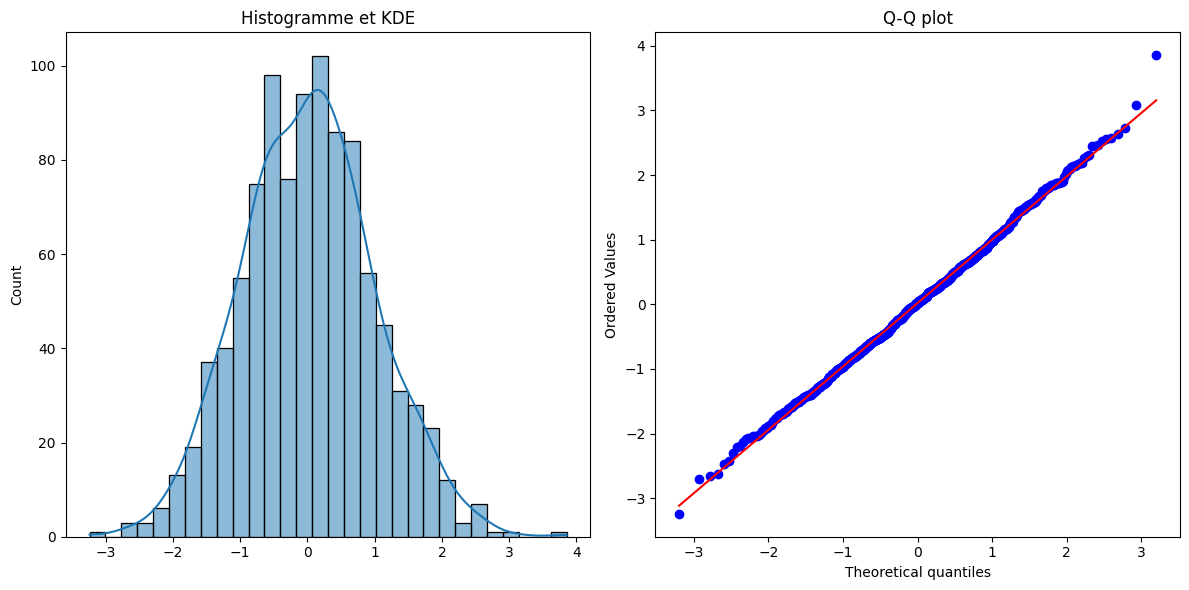

Test de Shapiro-Wilk: Statistique = 0.9986082911491394, p-value = 0.6266290545463562
Les données suivent une distribution normale (p > 0.05).
Test de Kolmogorov-Smirnov: Statistique = 0.017327787320720822, p-value = 0.9196626608357358
Les données suivent une distribution normale (p > 0.05).
Test de D'Agostino: Statistique = 2.5755178543216046, p-value = 0.2758883767428564
Les données suivent une distribution normale (p > 0.05).


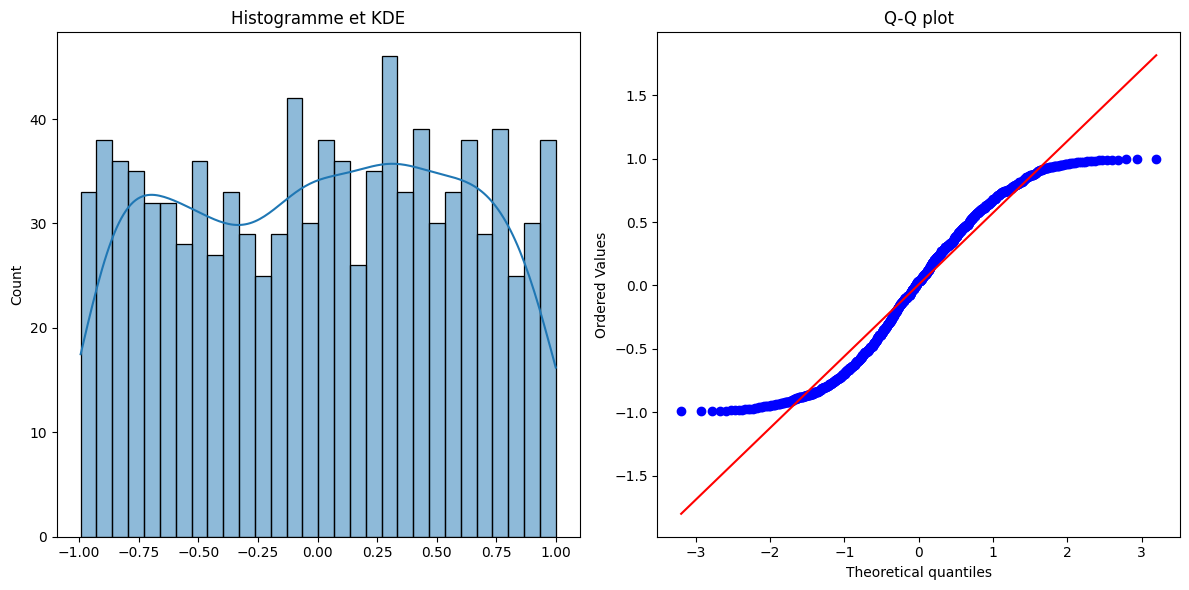

Test de Shapiro-Wilk: Statistique = 0.9542557001113892, p-value = 4.179905431758264e-17
Les données ne suivent pas une distribution normale (p <= 0.05).
Test de Kolmogorov-Smirnov: Statistique = 0.16021771733720358, p-value = 6.821915635229206e-23
Les données ne suivent pas une distribution normale (p <= 0.05).
Test de D'Agostino: Statistique = 710.3700937798964, p-value = 5.560246957701468e-155
Les données ne suivent pas une distribution normale (p <= 0.05).


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def check_gaussian_distribution(X):
    """
    Fonction pour vérifier si les données suivent une distribution gaussienne
    :param X: Données d'entrée (numpy array ou pandas DataFrame)
    """
    # 1. Visualisation avec un histogramme et un Q-Q plot
    plt.figure(figsize=(12, 6))

    # Histogramme
    plt.subplot(1, 2, 1)
    sns.histplot(X, kde=True, bins=30)
    plt.title('Histogramme et KDE')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(X, dist="norm", plot=plt)
    plt.title('Q-Q plot')

    plt.tight_layout()
    plt.show()

    # 2. Tests statistiques pour vérifier la normalité des données

    # Test de Shapiro-Wilk
    shapiro_stat, shapiro_p_value = stats.shapiro(X)
    print(f"Test de Shapiro-Wilk: Statistique = {shapiro_stat}, p-value = {shapiro_p_value}")
    if shapiro_p_value > 0.05:
        print("Les données suivent une distribution normale (p > 0.05).")
    else:
        print("Les données ne suivent pas une distribution normale (p <= 0.05).")

    # Test de Kolmogorov-Smirnov (test plus général pour la normalité)
    ks_stat, ks_p_value = stats.kstest(X, 'norm')
    print(f"Test de Kolmogorov-Smirnov: Statistique = {ks_stat}, p-value = {ks_p_value}")
    if ks_p_value > 0.05:
        print("Les données suivent une distribution normale (p > 0.05).")
    else:
        print("Les données ne suivent pas une distribution normale (p <= 0.05).")

    # Test de D'Agostino et Pearson (test de normalité basé sur la skewness et kurtosis)
    dagostino_stat, dagostino_p_value = stats.normaltest(X)
    print(f"Test de D'Agostino: Statistique = {dagostino_stat}, p-value = {dagostino_p_value}")
    if dagostino_p_value > 0.05:
        print("Les données suivent une distribution normale (p > 0.05).")
    else:
        print("Les données ne suivent pas une distribution normale (p <= 0.05).")

# Exemple d'utilisation avec des données simulées
np.random.seed(42)
X_normal = np.random.normal(loc=0, scale=1, size=1000)  # Données normales (moyenne = 0, écart-type = 1)
check_gaussian_distribution(X_normal)

# Exemple avec des données non normales (par exemple, une distribution uniforme)
X_uniform = np.random.uniform(low=-1, high=1, size=1000)
check_gaussian_distribution(X_uniform)


           Gene  Importance
171    Gene_172    0.019998
1773  Gene_1774    0.019441
562    Gene_563    0.012882
1154  Gene_1155    0.011883
804    Gene_805    0.011187
5        Gene_6    0.010876
817    Gene_818    0.010545
1379  Gene_1380    0.010032
1183  Gene_1184    0.009551
1898  Gene_1899    0.009158


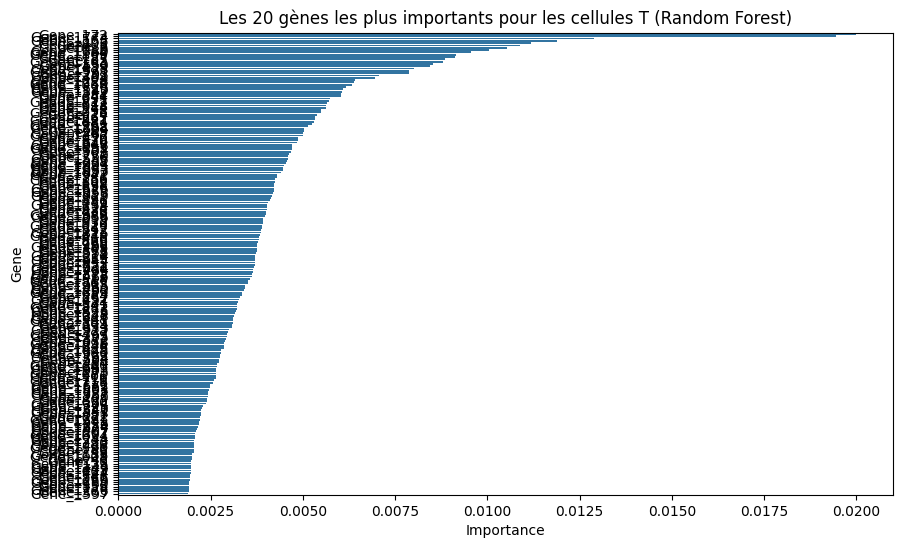

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns

# Exemple de données fictives (remplace avec tes vraies données)
# X_train : gènes (chaque colonne est un gène, chaque ligne une cellule)
# y_train : étiquettes des classes (ici, les cellules T)
X_train = np.random.randn(100, 2000)  # Exemple : 100 échantillons, 2000 gènes
y_train = np.random.choice(['T_cells_CD4+', 'T_cells_CD8+', 'Cancer_cells', 'NK_cells'], 100)

# Convertir en DataFrame pour faciliter l'analyse
gene_names = [f"Gene_{i+1}" for i in range(X_train.shape[1])]
X_train_df = pd.DataFrame(X_train, columns=gene_names)
y_train_df = pd.Series(y_train)

# Sélectionner uniquement les cellules T
T_cells_indices = y_train_df.isin(['T_cells_CD4+', 'T_cells_CD8+'])
X_train_tcells = X_train_df[T_cells_indices]
y_train_tcells = y_train_df[T_cells_indices]

# Diviser les données en train/test (80/20)
X_train_tcells, X_test_tcells, y_train_tcells, y_test_tcells = train_test_split(
    X_train_tcells, y_train_tcells, test_size=0.2, random_state=42
)

# Entraîner un Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tcells, y_train_tcells)

# Extraire l'importance des gènes
feature_importances = rf.feature_importances_

# Créer un DataFrame avec l'importance des gènes
importance_df = pd.DataFrame({
    'Gene': gene_names,
    'Importance': feature_importances
})

# Trier par importance décroissante
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les 10 gènes les plus importants
print(importance_df.head(10))

# Visualisation des 20 gènes les plus importants
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Gene', data=importance_df.head(200))
plt.title("Les 20 gènes les plus importants pour les cellules T (Random Forest)")
plt.show()


/var/folders/h2/9ggxct057yb8cggcxrpf4p640000gn/T/ipykernel_89451/2765498005.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cell Class', y=gene, data=df, palette='Set2')
/var/folders/h2/9ggxct057yb8cggcxrpf4p640000gn/T/ipykernel_89451/2765498005.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cell Class', y=gene, data=df, palette='Set2')
/var/folders/h2/9ggxct057yb8cggcxrpf4p640000gn/T/ipykernel_89451/2765498005.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cell Class', y=gene, data=df, palette='Set2')
/var/folders/

ValueError: num must be an integer with 1 <= num <= 10, not 11

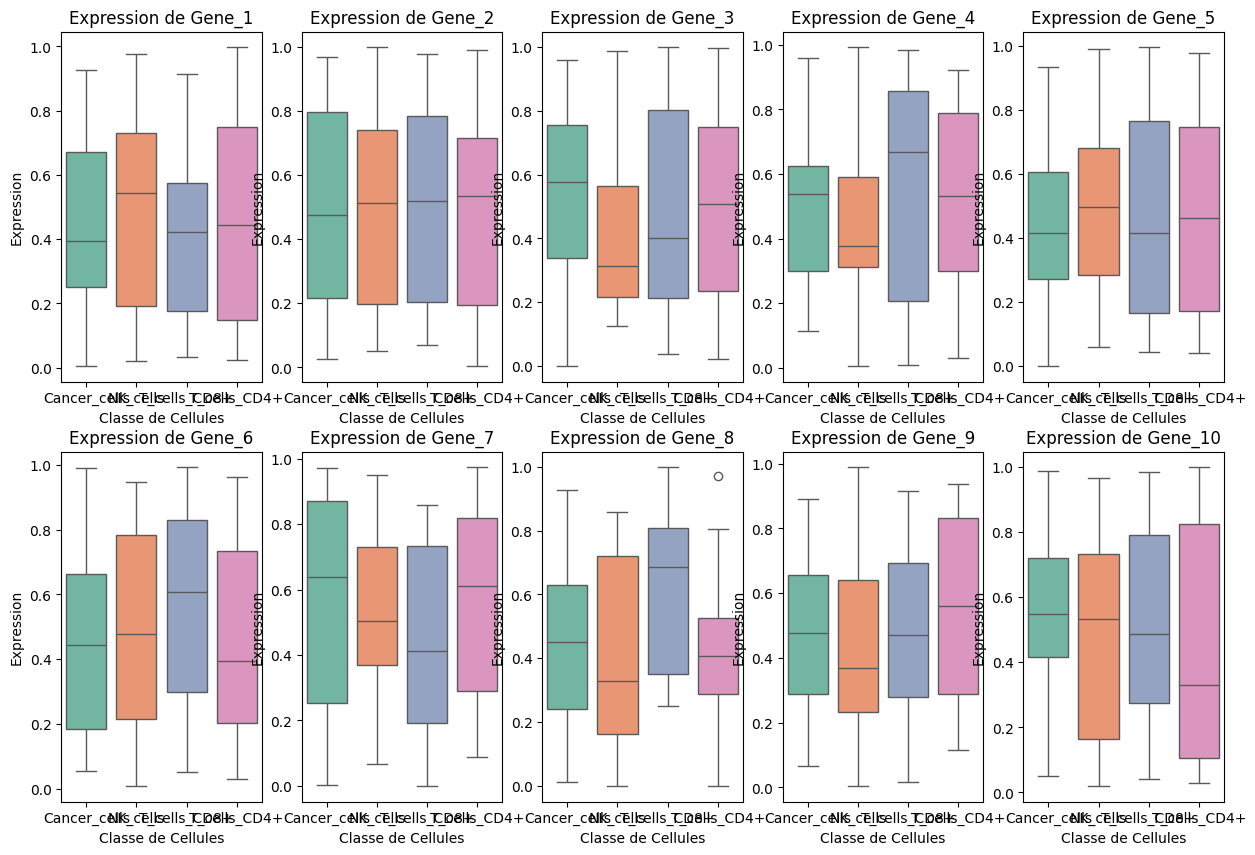

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exemple de données d'expression des gènes (matrice d'expression)
# X_train : matrice de taille (n_samples, n_genes)
# y_train : vecteur de taille (n_samples,) contenant les classes des cellules

# Ici, nous supposons que X_train contient des valeurs d'expression pour chaque gène (exemple aléatoire)
import numpy as np

# Exemple fictif de données
np.random.seed(42)
n_samples = 100
n_genes = 100

# Matrice d'expression (n_samples, n_genes)
X_train = np.random.rand(n_samples, n_genes)

# Étiquettes des classes (par exemple, les 4 classes : T_cells_CD4+, T_cells_CD8+, Cancer_cells, NK_cells)
y_train = np.random.choice(['T_cells_CD4+', 'T_cells_CD8+', 'Cancer_cells', 'NK_cells'], size=n_samples)

# Conversion en DataFrame pour faciliter la manipulation
df = pd.DataFrame(X_train, columns=[f'Gene_{i+1}' for i in range(n_genes)])
df['Cell Class'] = y_train  # Ajout des étiquettes de classe

# Création d'un boxplot pour chaque gène
plt.figure(figsize=(15, 10))

# Pour chaque gène, créer un box plot
for i, gene in enumerate(df.columns[:-1]):  # Exclure la colonne 'Cell Class'
    plt.subplot(2, 5, i+1)  # Créer une grille de subplots (2 lignes, 5 colonnes)
    
    # Créer le boxplot pour ce gène, en fonction des classes de cellules
    sns.boxplot(x='Cell Class', y=gene, data=df, palette='Set2')
    
    plt.title(f"Expression de {gene}")
    plt.xlabel("Classe de Cellules")
    plt.ylabel("Expression")

plt.tight_layout()  # Ajuster l'espacement entre les graphiques
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression  # Import de LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif  # Import de SelectKBest

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, k_best_features=5500):
        self.k_best_features = k_best_features  # Nombre de caractéristiques à sélectionner
        self.selector = SelectKBest(score_func=f_classif, k=self.k_best_features)  # Sélecteur de caractéristiques

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # Sélection des meilleures caractéristiques avec SelectKBest
        X_bal = self.selector.fit_transform(X_bal, y_bal)  # Sélectionner les k meilleures caractéristiques

        self.X_train_ = X_bal
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X = self.selector.transform(X)  # Sélectionner les mêmes caractéristiques sur le test set
        return X


# ---------------- Classifier ----------------
class HClassifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = LogisticRegression(random_state=42, max_iter=1000)  # Utilisation de LogisticRegression

    def fit(self, X, y):
        # Appliquer le préprocesseur (normalisation, imputation, sélection des caractéristiques)
        self.preprocessor.fit(X, y)

        # Paramètres pour GridSearchCV
        param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],  # Paramètre de régularisation (inversé)
            'penalty': ['l2', 'elasticnet'],  # Types de régularisation (L2 ou Elasticnet)
            'solver': ['lbfgs', 'liblinear', 'saga'],  # Solveurs différents
            'max_iter': [500, 1000],  # Nombre d'itérations maximales pour la convergence
            'multi_class': ['ovr', 'multinomial']  # Méthode pour gérer la classification multiclasse
        }

        # GridSearchCV pour trouver les meilleurs hyperparamètres
        grid_search = GridSearchCV(self.model, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
        grid_search.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

        # Récupérer le meilleur modèle
        self.model = grid_search.best_estimator_
        print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)


# ---------------- Hierarchical Classifier ----------------
class Classifier:
    def __init__(self):
        # Étape 1 : séparer les groupes
        self.clf_step1 = HClassifier()
        # Étape 2 : classifier à l'intérieur des groupes
        self.clf_step2_group1 = HClassifier()  # Cancer vs NK
        self.clf_step2_group2 = HClassifier()  # CD4+ vs CD8+

    def fit(self, X, y):
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Sous-groupe 1 : Cancer vs NK
        mask_group1 = np.array([label in ['Cancer_cells','NK_cells'] for label in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Sous-groupe 2 : CD4+ vs CD8+
        mask_group2 = np.array([label in ['T_cells_CD4+','T_cells_CD8+'] for label in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred


# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données : X_train, y_train, X_test, y_test
hier_clf = Classifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)


Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier

Best parameters from GridSearchCV: {'C': 1, 'max_iter': 500, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   33    45   163   220   222   287   490   515   535   845  1279  1305
  1306  1327  1434  1450  1460  1558  1786  1823  1830  1864  1891  1943
  2220  2301  2303  2374  2431  2441  2594  2632  2645  2693  2780  3076
  3097  3338  3417  3663  3806  3856  3926  3927  4066  4130  4156  4166
  4277  4459  4545  4559  4612  4653  4671  4996  5095  5098  5289  5325
  5433  5547  5588  5590  5605  5617  5747  6006  6008  6027  6043  6055
  6088  6195  6227  6537  7278  7416  7811  7828  7833  7967  7984  8044
  8088  8357  8434  8552  8556  8695  8763  8822  9196  9358  9451  9560
  9576  9598  9605  9608  9614  9615  9633  9647  9675  9687  9688  9703
  9715  9716  9717  9908 10131 10139 10150 10391 10746 10823 11052 11225
 11303 11430 11602 11608 11760 11878 12177 12270 12409 12497 12760 12762
 1287

KeyboardInterrupt: 